### Interpretation 2: Overall IAA Performance Segmented by Style

In [15]:
"""
Style-Specific Inter-Annotator Agreement Analysis
================================================

This script extends the Krippendorff's Alpha analysis to examine agreement
per image style across different coverage levels (2+, 3+, 4 experts).

Key Features:
- Maps IAA images to their ground truth styles using the CSV mapping
- Handles case sensitivity differences between annotations and mapping
- Calculates Krippendorff's Alpha for each style separately
- Analyzes agreement patterns across 10 different image styles
- Provides detailed statistics and tables for each coverage category

Author: Thesis Analysis - Style Extension
Date: June 2025
"""

import json
import os
import pandas as pd
import numpy as np
import krippendorff
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FILE PATHS AND CONFIGURATION
# ============================================================================

# Define file paths (same as your original script)
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# Expert annotation files
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

# Mapping file
MAPPING_FILE = 'renamed_images_mapping.csv'

# Define the 6 scaled dimensions (same as your original)
SCALED_DIMENSIONS = {
    'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
    'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
    'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
    'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
}

# Known styles (as they appear in the CSV - lowercase)
KNOWN_STYLES = [
    '3d rendered', 'artistic', 'cartoon', 'digital art', 'geometric', 
    'minimalistic', 'realistic', 'retro', 'storybook', 'technical'
]

# ============================================================================
# UTILITY FUNCTIONS (Reusing from your original script)
# ============================================================================

def convert_score_to_category(score, scale_max):
    """Convert numerical scores to ordinal categories based on scale range."""
    if score is None or pd.isna(score):
        return None
    
    if scale_max == 15:
        if 0 <= score <= 3: return 0      # Very Low
        elif 4 <= score <= 6: return 1    # Low
        elif 7 <= score <= 9: return 2    # Medium
        elif 10 <= score <= 12: return 3  # High
        elif 13 <= score <= 15: return 4  # Very High
    elif scale_max == 20:
        if 0 <= score <= 4: return 0      # Very Low
        elif 5 <= score <= 8: return 1    # Low
        elif 9 <= score <= 12: return 2   # Medium
        elif 13 <= score <= 16: return 3  # High
        elif 17 <= score <= 20: return 4  # Very High
    
    return None

def get_category_name(category_code):
    """Convert category code back to human-readable name."""
    category_names = {0: "Very Low", 1: "Low", 2: "Medium", 3: "High", 4: "Very High"}
    return category_names.get(category_code, "Unknown")

def interpret_alpha(alpha_value):
    """Interpret Krippendorff's Alpha values according to standard guidelines."""
    if alpha_value is None:
        return "No data"
    elif alpha_value < 0:
        return "Poor (systematic disagreement)"
    elif alpha_value < 0.20:
        return "Poor"
    elif alpha_value < 0.40:
        return "Fair"
    elif alpha_value < 0.60:
        return "Moderate"
    elif alpha_value < 0.80:
        return "Good"
    else:
        return "Excellent"

# ============================================================================
# STYLE MAPPING FUNCTIONS
# ============================================================================

def load_style_mapping():
    """
    Load the CSV mapping file and create a lookup dictionary.
    
    Returns:
        dict: Mapping from new_filename to style information
    """
    print("Loading style mapping...")
    
    mapping_path = os.path.join(MAPPING_DIR, MAPPING_FILE)
    
    try:
        df_mapping = pd.read_csv(mapping_path)
        print(f"✓ Loaded mapping for {len(df_mapping)} images")
        
        # Create lookup dictionary: new_filename -> style
        style_mapping = {}
        for _, row in df_mapping.iterrows():
            new_filename = row['new_filename']
            style = row['style'].lower().strip()  # Normalize to lowercase
            style_mapping[new_filename] = style
        
        # Print style distribution
        style_counts = pd.Series(list(style_mapping.values())).value_counts()
        print(f"\nStyle distribution in mapping:")
        for style, count in style_counts.items():
            print(f"  {style}: {count} images")
        
        return style_mapping
        
    except FileNotFoundError:
        print(f"✗ ERROR: Could not find {MAPPING_FILE}")
        return None
    except Exception as e:
        print(f"✗ ERROR loading mapping: {e}")
        return None

def get_style_from_filename(filename, style_mapping):
    """
    Extract style from filename using the mapping.
    
    Args:
        filename (str): The image filename (e.g., "0008_IAA.png")
        style_mapping (dict): Mapping from new_filename to style
    
    Returns:
        str: The style of the image, or None if not found
    """
    # Remove _IAA suffix if present
    base_filename = filename.replace('_IAA', '')
    
    if base_filename in style_mapping:
        return style_mapping[base_filename]
    
    # Try alternative approaches if direct lookup fails
    for mapped_filename, style in style_mapping.items():
        if mapped_filename.replace('.png', '') == base_filename.replace('.png', ''):
            return style
    
    return None

# ============================================================================
# DATA LOADING AND PROCESSING (Extended for Style Analysis)
# ============================================================================

def load_annotation_data():
    """Load all expert annotation JSON files."""
    print("Loading annotation data...")
    print("=" * 50)
    
    expert_data = {}
    
    for expert, filename in ANNOTATION_FILES.items():
        file_path = os.path.join(ANNOTATION_DIR, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            expert_data[expert] = data
            print(f"✓ Loaded {len(data)} annotations for {expert}")
        except Exception as e:
            print(f"✗ ERROR loading {filename}: {e}")
            return None
    
    print(f"\nTotal experts loaded: {len(expert_data)}")
    return expert_data

def extract_scores_from_annotation(annotation_result):
    """Extract numerical scores from Label Studio annotation result."""
    scores = {}
    
    field_mapping = {
        'img_simplicity': 'img_simplicity',
        'img_quality': 'img_quality', 
        'txt_simplicity': 'txt_simplicity',
        'txt_quality': 'txt_quality',
        'ethics': 'ethics',
        'txt_img_align': 'txt_img_align'
    }
    
    for item in annotation_result:
        if item.get('type') == 'number':
            from_name = item.get('from_name')
            value = item.get('value', {}).get('number')
            
            if from_name in field_mapping and value is not None:
                scores[field_mapping[from_name]] = value
    
    return scores

def get_iaa_annotations_by_style_and_coverage():
    """
    Extract IAA annotations organized by both style and coverage level.
    
    Returns:
        tuple: (style_coverage_groups, expert_annotations, style_mapping)
    """
    print("\nExtracting IAA annotations by style...")
    print("=" * 60)
    
    # Load style mapping
    style_mapping = load_style_mapping()
    if style_mapping is None:
        return None, None, None
    
    # Load expert data
    expert_data = load_annotation_data()
    if expert_data is None:
        return None, None, None
    
    # Extract IAA annotations for each expert
    expert_annotations = {}
    expert_iaa_images = {}
    
    for expert, data in expert_data.items():
        annotations_dict = {}
        iaa_images = set()
        
        for record in data:
            filename = record['data']['original_filename']
            
            # Only process IAA images
            if '_IAA' in filename:
                iaa_images.add(filename)
                
                if record['annotations'] and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]['result']
                    scores = extract_scores_from_annotation(annotation)
                    annotations_dict[filename] = scores
        
        expert_annotations[expert] = annotations_dict
        expert_iaa_images[expert] = iaa_images
        
        print(f"  {expert}: {len(iaa_images)} IAA images annotated")
    
    # Organize by style and coverage
    print(f"\nOrganizing by style and coverage...")
    
    # First, find all IAA images and their styles
    all_iaa_images = set()
    for expert_images in expert_iaa_images.values():
        all_iaa_images.update(expert_images)
    
    # Map images to styles
    image_style_mapping = {}
    images_without_style = []
    
    for image in all_iaa_images:
        style = get_style_from_filename(image, style_mapping)
        if style:
            image_style_mapping[image] = style
        else:
            images_without_style.append(image)
    
    if images_without_style:
        print(f"⚠ Warning: {len(images_without_style)} images without style mapping:")
        for img in images_without_style[:5]:  # Show first 5
            print(f"    {img}")
        if len(images_without_style) > 5:
            print(f"    ... and {len(images_without_style) - 5} more")
    
    # Count expert coverage for each image
    image_expert_count = defaultdict(list)
    for expert, images in expert_iaa_images.items():
        for image in images:
            if image in image_style_mapping:  # Only count images with known styles
                image_expert_count[image].append(expert)
    
    # Organize by style and coverage level
    style_coverage_groups = {}
    
    for style in KNOWN_STYLES:
        style_coverage_groups[style] = {
            '4_experts': set(),
            '3plus_experts': set(),
            '2plus_experts': set()
        }
    
    # Assign images to style-coverage groups
    for image, experts_list in image_expert_count.items():
        style = image_style_mapping[image]
        coverage = len(experts_list)
        
        if coverage >= 4:
            style_coverage_groups[style]['4_experts'].add(image)
            style_coverage_groups[style]['3plus_experts'].add(image)
            style_coverage_groups[style]['2plus_experts'].add(image)
        elif coverage >= 3:
            style_coverage_groups[style]['3plus_experts'].add(image)
            style_coverage_groups[style]['2plus_experts'].add(image)
        elif coverage >= 2:
            style_coverage_groups[style]['2plus_experts'].add(image)
    
    # Print summary
    print(f"\nStyle-Coverage Summary:")
    print(f"{'Style':<15} {'2+ Experts':<12} {'3+ Experts':<12} {'4 Experts':<10}")
    print("-" * 55)
    
    for style in KNOWN_STYLES:
        count_2 = len(style_coverage_groups[style]['2plus_experts'])
        count_3 = len(style_coverage_groups[style]['3plus_experts'])
        count_4 = len(style_coverage_groups[style]['4_experts'])
        print(f"{style:<15} {count_2:<12} {count_3:<12} {count_4:<10}")
    
    return style_coverage_groups, expert_annotations, image_style_mapping

# ============================================================================
# STYLE-SPECIFIC KRIPPENDORFF'S ALPHA CALCULATION
# ============================================================================

def prepare_style_data_for_krippendorff(image_set, expert_annotations, dimension):
    """
    Prepare annotation data for Krippendorff's Alpha calculation.
    Same as your original function but for specific image sets.
    """
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    sorted_images = sorted(image_set)
    data_matrix = []
    
    for expert in experts:
        expert_row = []
        
        for image in sorted_images:
            if (expert in expert_annotations and 
                image in expert_annotations[expert] and 
                dimension in expert_annotations[expert][image]):
                
                raw_score = expert_annotations[expert][image][dimension]
                category = convert_score_to_category(raw_score, scale_max)
                
                if category is not None:
                    expert_row.append(int(category))
                else:
                    expert_row.append(np.nan)
            else:
                expert_row.append(np.nan)
        
        data_matrix.append(expert_row)
    
    return np.array(data_matrix, dtype=float)

def calculate_style_specific_alpha(style_coverage_groups, expert_annotations, dimension, coverage_level):
    """
    Calculate Krippendorff's Alpha for each style within a coverage level.
    
    Args:
        style_coverage_groups (dict): Style -> coverage -> images mapping
        expert_annotations (dict): Expert annotations
        dimension (str): Dimension to analyze
        coverage_level (str): Coverage level ('2plus_experts', '3plus_experts', '4_experts')
    
    Returns:
        dict: Style -> alpha results mapping
    """
    results = {}
    
    for style in KNOWN_STYLES:
        image_set = style_coverage_groups[style][coverage_level]
        
        if len(image_set) == 0:
            results[style] = {
                'alpha': None,
                'n_images': 0,
                'n_annotations': 0,
                'interpretation': 'No images',
                'sufficient_data': False
            }
            continue
        
        # Prepare data matrix
        data_matrix = prepare_style_data_for_krippendorff(image_set, expert_annotations, dimension)
        total_annotations = int(np.sum(~np.isnan(data_matrix)))
        
        # Need minimum data for meaningful alpha
        sufficient_data = total_annotations >= 4 and len(image_set) >= 2
        
        if not sufficient_data:
            alpha_value = None
            interpretation = "Insufficient data"
        else:
            try:
                alpha_value = krippendorff.alpha(
                    reliability_data=data_matrix,
                    level_of_measurement='ordinal'
                )
                interpretation = interpret_alpha(alpha_value)
            except Exception as e:
                alpha_value = None
                interpretation = "Calculation error"
        
        results[style] = {
            'alpha': alpha_value,
            'n_images': len(image_set),
            'n_annotations': total_annotations,
            'interpretation': interpretation,
            'sufficient_data': sufficient_data
        }
    
    return results

def run_style_specific_analysis():
    """
    Run the complete style-specific Krippendorff's Alpha analysis.
    
    Returns:
        dict: Complete results organized by dimension -> coverage -> style
    """
    print("=" * 80)
    print("STYLE-SPECIFIC KRIPPENDORFF'S ALPHA ANALYSIS")
    print("=" * 80)
    
    # Get style-organized data
    style_coverage_groups, expert_annotations, image_style_mapping = get_iaa_annotations_by_style_and_coverage()
    if style_coverage_groups is None:
        print("ERROR: Could not load style-organized data")
        return None
    
    # Run analysis for each dimension and coverage level
    all_results = {}
    coverage_levels = ['2plus_experts', '3plus_experts', '4_experts']
    
    for dimension in SCALED_DIMENSIONS.keys():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        print(f"\n{'-' * 70}")
        print(f"ANALYZING: {display_name} (0-{scale_max} scale)")
        print(f"{'-' * 70}")
        
        dimension_results = {}
        
        for coverage_level in coverage_levels:
            print(f"\n{coverage_level.replace('_', ' ').title()}:")
            
            style_results = calculate_style_specific_alpha(
                style_coverage_groups, expert_annotations, dimension, coverage_level
            )
            
            dimension_results[coverage_level] = style_results
            
            # Print summary for this coverage level
            valid_alphas = [r['alpha'] for r in style_results.values() 
                          if r['alpha'] is not None and r['sufficient_data']]
            
            if valid_alphas:
                mean_alpha = np.mean(valid_alphas)
                print(f"  Mean α across styles: {mean_alpha:.3f} ({interpret_alpha(mean_alpha)})")
                print(f"  Styles with sufficient data: {len(valid_alphas)}/{len(KNOWN_STYLES)}")
            else:
                print(f"  No styles with sufficient data")
        
        all_results[dimension] = dimension_results
    
    return all_results, style_coverage_groups, expert_annotations, image_style_mapping

# ============================================================================
# REPORTING AND VISUALIZATION FUNCTIONS
# ============================================================================

def create_style_summary_tables(all_results):
    """
    Create comprehensive summary tables for style-specific IAA results.
    
    Args:
        all_results (dict): Complete results from style analysis
    """
    print(f"\n{'=' * 100}")
    print("STYLE-SPECIFIC IAA SUMMARY TABLES")
    print(f"{'=' * 100}")
    
    coverage_levels = ['2plus_experts', '3plus_experts', '4_experts']
    
    for coverage_level in coverage_levels:
        print(f"\n{'-' * 80}")
        print(f"{coverage_level.replace('_', ' ').title()} Coverage")
        print(f"{'-' * 80}")
        
        # Create table data
        table_data = []
        
        for dimension in SCALED_DIMENSIONS.keys():
            display_name = SCALED_DIMENSIONS[dimension]['display_name']
            
            if dimension in all_results and coverage_level in all_results[dimension]:
                style_results = all_results[dimension][coverage_level]
                
                for style in KNOWN_STYLES:
                    if style in style_results:
                        result = style_results[style]
                        
                        alpha_str = f"{result['alpha']:.3f}" if result['alpha'] is not None else "N/A"
                        
                        table_data.append({
                            'Dimension': display_name,
                            'Style': style.title(),
                            'Alpha': alpha_str,
                            'Interpretation': result['interpretation'],
                            'Images': result['n_images'],
                            'Annotations': result['n_annotations'],
                            'Sufficient': result['sufficient_data']
                        })
        
        # Create and display DataFrame
        if table_data:
            df_table = pd.DataFrame(table_data)
            print(df_table.to_string(index=False))
            
            # Calculate statistics for this coverage level
            valid_alphas = [float(row['Alpha']) for _, row in df_table.iterrows() 
                          if row['Alpha'] != 'N/A' and row['Sufficient']]
            
            if valid_alphas:
                print(f"\nStatistics for {coverage_level.replace('_', ' ').title()}:")
                print(f"  Mean α: {np.mean(valid_alphas):.3f}")
                print(f"  Std α: {np.std(valid_alphas):.3f}")
                print(f"  Min α: {min(valid_alphas):.3f}")
                print(f"  Max α: {max(valid_alphas):.3f}")
                print(f"  Valid measurements: {len(valid_alphas)}")

def create_style_agreement_summary(all_results):
    """
    Create a summary showing which styles have highest/lowest agreement.
    
    Args:
        all_results (dict): Complete results from style analysis
    """
    print(f"\n{'=' * 80}")
    print("STYLE AGREEMENT RANKING")
    print(f"{'=' * 80}")
    
    coverage_levels = ['2plus_experts', '3plus_experts', '4_experts']
    
    for coverage_level in coverage_levels:
        print(f"\n{coverage_level.replace('_', ' ').title()}:")
        print("-" * 40)
        
        # Collect all alpha values for each style across dimensions
        style_alphas = defaultdict(list)
        
        for dimension in SCALED_DIMENSIONS.keys():
            if dimension in all_results and coverage_level in all_results[dimension]:
                style_results = all_results[dimension][coverage_level]
                
                for style in KNOWN_STYLES:
                    if (style in style_results and 
                        style_results[style]['alpha'] is not None and 
                        style_results[style]['sufficient_data']):
                        style_alphas[style].append(style_results[style]['alpha'])
        
        # Calculate mean alpha for each style
        style_mean_alphas = {}
        for style, alphas in style_alphas.items():
            if alphas:
                style_mean_alphas[style] = np.mean(alphas)
        
        # Sort by agreement level
        if style_mean_alphas:
            sorted_styles = sorted(style_mean_alphas.items(), key=lambda x: x[1], reverse=True)
            
            print("Rank  Style              Mean α    Interpretation")
            print("-" * 50)
            for i, (style, mean_alpha) in enumerate(sorted_styles, 1):
                interpretation = interpret_alpha(mean_alpha)
                print(f"{i:2d}.   {style.title():<15} {mean_alpha:.3f}     {interpretation}")
        else:
            print("No valid data for ranking")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("Starting Style-Specific IAA Analysis...")
    
    # Run the analysis
    results = run_style_specific_analysis()
    
    if results is not None:
        all_results, style_coverage_groups, expert_annotations, image_style_mapping = results
        
        # Create detailed tables
        create_style_summary_tables(all_results)
        
        # Create style ranking summary
        create_style_agreement_summary(all_results)
        
        print(f"\n{'=' * 80}")
        print("STYLE-SPECIFIC ANALYSIS COMPLETE!")
        print(f"{'=' * 80}")
        print("Results stored in 'all_results' variable")
        print("Style coverage groups stored in 'style_coverage_groups' variable")
        print("Image style mapping stored in 'image_style_mapping' variable")
        
        # Store results for visualization
        style_iaa_results = all_results
        
    else:
        print("Analysis failed. Please check file paths and data format.")

Starting Style-Specific IAA Analysis...
STYLE-SPECIFIC KRIPPENDORFF'S ALPHA ANALYSIS

Extracting IAA annotations by style...
Loading style mapping...
✓ Loaded mapping for 2000 images

Style distribution in mapping:
  artistic: 200 images
  technical: 200 images
  cartoon: 200 images
  realistic: 200 images
  storybook: 200 images
  3d rendered: 200 images
  geometric: 200 images
  retro: 200 images
  minimalistic: 200 images
  digital art: 200 images
Loading annotation data...
✓ Loaded 250 annotations for Expert_A
✓ Loaded 250 annotations for Expert_K
✓ Loaded 200 annotations for Expert_L
✓ Loaded 276 annotations for Expert_M

Total experts loaded: 4
  Expert_A: 71 IAA images annotated
  Expert_K: 81 IAA images annotated
  Expert_L: 61 IAA images annotated
  Expert_M: 84 IAA images annotated

Organizing by style and coverage...

Style-Coverage Summary:
Style           2+ Experts   3+ Experts   4 Experts 
-------------------------------------------------------
3d rendered     11        

Interpretation 1: Style Classification Agreement Only

In [22]:
"""
Style Classification Inter-Annotator Agreement Analysis
======================================================

This script analyzes inter-annotator agreement specifically for style classification
using Krippendorff's Alpha for set-valued data. Experts selected up to 3 styles
per image from 10 possible styles.

Key Features:
- Focuses only on the 'image_style' question (ignores numerical ratings)
- Uses Krippendorff's Alpha for set-valued/multi-label data
- Analyzes agreement on style identification across coverage levels
- Compares expert style selections vs ground truth styles
- Provides both overall and per-style agreement metrics

Author: Thesis Analysis - Style Classification
Date: June 2025
"""

import json
import os
import pandas as pd
import numpy as np
import krippendorff
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FILE PATHS AND CONFIGURATION
# ============================================================================

# Define file paths
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# Expert annotation files
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

# Mapping file
MAPPING_FILE = 'renamed_images_mapping.csv'

# Known styles (as they appear in annotations - with capital letters)
ANNOTATION_STYLES = [
    '3D Rendered', 'Artistic', 'Cartoon', 'Digital Art', 'Geometric', 
    'Minimalistic', 'Realistic', 'Retro', 'Storybook', 'Technical'
]

# Mapping to CSV styles (lowercase)
STYLE_MAPPING = {
    '3D Rendered': '3d rendered',
    'Artistic': 'artistic',
    'Cartoon': 'cartoon', 
    'Digital Art': 'digital art',
    'Geometric': 'geometric',
    'Minimalistic': 'minimalistic',
    'Realistic': 'realistic',
    'Retro': 'retro',
    'Storybook': 'storybook',
    'Technical': 'technical'
}

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def interpret_alpha(alpha_value):
    """Interpret Krippendorff's Alpha values according to standard guidelines."""
    if alpha_value is None:
        return "No data"
    elif alpha_value < 0:
        return "Poor (systematic disagreement)"
    elif alpha_value < 0.20:
        return "Poor"
    elif alpha_value < 0.40:
        return "Fair"
    elif alpha_value < 0.60:
        return "Moderate"
    elif alpha_value < 0.80:
        return "Good"
    else:
        return "Excellent"

def normalize_style_name(style_name):
    """Normalize style names to handle case variations."""
    # Handle common variations
    style_name = style_name.strip()
    
    # Map known variations
    style_variations = {
        '3d rendered': '3D Rendered',
        '3D rendered': '3D Rendered',
        '3d Rendered': '3D Rendered'
    }
    
    if style_name in style_variations:
        return style_variations[style_name]
    
    # Default: title case
    return style_name.title()

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_style_mapping():
    """Load the CSV mapping file and create style lookup."""
    print("Loading style mapping...")
    
    mapping_path = os.path.join(MAPPING_DIR, MAPPING_FILE)
    
    try:
        df_mapping = pd.read_csv(mapping_path)
        print(f"✓ Loaded mapping for {len(df_mapping)} images")
        
        # Create lookup dictionary: new_filename -> style
        style_mapping = {}
        for _, row in df_mapping.iterrows():
            new_filename = row['new_filename']
            style = row['style'].lower().strip()
            style_mapping[new_filename] = style
        
        return style_mapping
        
    except FileNotFoundError:
        print(f"✗ ERROR: Could not find {MAPPING_FILE}")
        return None
    except Exception as e:
        print(f"✗ ERROR loading mapping: {e}")
        return None

def load_annotation_data():
    """Load all expert annotation JSON files."""
    print("Loading annotation data...")
    print("=" * 50)
    
    expert_data = {}
    
    for expert, filename in ANNOTATION_FILES.items():
        file_path = os.path.join(ANNOTATION_DIR, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            expert_data[expert] = data
            print(f"✓ Loaded {len(data)} annotations for {expert}")
        except Exception as e:
            print(f"✗ ERROR loading {filename}: {e}")
            return None
    
    print(f"\nTotal experts loaded: {len(expert_data)}")
    return expert_data

def extract_style_choices_from_annotation(annotation_result):
    """
    Extract style choices from Label Studio annotation result.
    
    Args:
        annotation_result (list): The 'result' field from Label Studio annotation
    
    Returns:
        set: Set of styles selected by the expert (normalized names)
    """
    style_choices = set()
    
    for item in annotation_result:
        if (item.get('type') == 'choices' and 
            item.get('from_name') == 'image_style'):
            
            choices = item.get('value', {}).get('choices', [])
            
            # Normalize style names and add to set
            for choice in choices:
                normalized_choice = normalize_style_name(choice)
                if normalized_choice in ANNOTATION_STYLES:
                    style_choices.add(normalized_choice)
    
    return style_choices

# ============================================================================
# STYLE CLASSIFICATION DATA PREPARATION
# ============================================================================

def get_style_classification_data():
    """
    Extract style classification data organized by coverage level.
    
    Returns:
        tuple: (coverage_groups, expert_style_selections, ground_truth_mapping)
    """
    print("\nExtracting style classification data...")
    print("=" * 60)
    
    # Load data
    expert_data = load_annotation_data()
    if expert_data is None:
        return None, None, None
        
    style_mapping = load_style_mapping()
    if style_mapping is None:
        return None, None, None
    
    # Extract style selections for each expert
    expert_style_selections = {}
    expert_iaa_images = {}
    
    for expert, data in expert_data.items():
        style_selections = {}
        iaa_images = set()
        
        for record in data:
            filename = record['data']['original_filename']
            
            # Only process IAA images
            if '_IAA' in filename:
                iaa_images.add(filename)
                
                if record['annotations'] and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]['result']
                    selected_styles = extract_style_choices_from_annotation(annotation)
                    style_selections[filename] = selected_styles
        
        expert_style_selections[expert] = style_selections
        expert_iaa_images[expert] = iaa_images
        
        print(f"  {expert}: {len(iaa_images)} IAA images with style annotations")
    
    # Create ground truth mapping
    ground_truth_mapping = {}
    
    def get_style_from_filename(filename, style_mapping):
        """Extract style from filename using the mapping."""
        base_filename = filename.replace('_IAA', '')
        
        if base_filename in style_mapping:
            csv_style = style_mapping[base_filename]
            # Convert CSV style to annotation style format
            for ann_style, csv_style_mapped in STYLE_MAPPING.items():
                if csv_style_mapped == csv_style:
                    return ann_style
        return None
    
    # Map all IAA images to ground truth styles
    all_iaa_images = set()
    for expert_images in expert_iaa_images.values():
        all_iaa_images.update(expert_images)
    
    for image in all_iaa_images:
        ground_truth_style = get_style_from_filename(image, style_mapping)
        if ground_truth_style:
            ground_truth_mapping[image] = ground_truth_style
    
    print(f"\nGround truth mapping: {len(ground_truth_mapping)} images")
    
    # Count expert coverage
    image_expert_count = defaultdict(list)
    for expert, images in expert_iaa_images.items():
        for image in images:
            if image in ground_truth_mapping:
                image_expert_count[image].append(expert)
    
    # Create coverage groups
    coverage_groups = {
        '4_experts': set(),
        '3plus_experts': set(),
        '2plus_experts': set()
    }
    
    for image, experts_list in image_expert_count.items():
        coverage = len(experts_list)
        
        if coverage >= 4:
            coverage_groups['4_experts'].add(image)
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 3:
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 2:
            coverage_groups['2plus_experts'].add(image)
    
    # Print coverage summary
    print(f"\nStyle Classification Coverage Summary:")
    print(f"  Images with 4 experts: {len(coverage_groups['4_experts'])}")
    print(f"  Images with 3+ experts: {len(coverage_groups['3plus_experts'])}")
    print(f"  Images with 2+ experts: {len(coverage_groups['2plus_experts'])}")
    
    return coverage_groups, expert_style_selections, ground_truth_mapping

# ============================================================================
# KRIPPENDORFF'S ALPHA FOR SET-VALUED DATA
# ============================================================================

def prepare_style_data_for_krippendorff(image_set, expert_style_selections):
    """
    Prepare style selection data for Krippendorff's Alpha calculation.
    Each expert's annotation becomes a set of selected styles.
    
    Args:
        image_set (set): Set of image filenames to analyze
        expert_style_selections (dict): Expert->image->styles mapping
    
    Returns:
        numpy.ndarray: Data matrix where each cell contains a frozenset of styles
    """
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    sorted_images = sorted(image_set)
    
    # Create data matrix: rows = annotators, columns = items (images)
    data_matrix = []
    
    for expert in experts:
        expert_row = []
        
        for image in sorted_images:
            if (expert in expert_style_selections and 
                image in expert_style_selections[expert]):
                
                # Get the set of styles selected by this expert for this image
                selected_styles = expert_style_selections[expert][image]
                
                # Convert to frozenset for Krippendorff's Alpha
                # Empty set if no styles selected
                if selected_styles:
                    expert_row.append(frozenset(selected_styles))
                else:
                    expert_row.append(frozenset())
            else:
                # Missing annotation
                expert_row.append(np.nan)
        
        data_matrix.append(expert_row)
    
    return np.array(data_matrix, dtype=object)

def calculate_style_classification_alpha(coverage_groups, expert_style_selections):
    """
    Calculate Krippendorff's Alpha for style classification across coverage levels.
    
    Args:
        coverage_groups (dict): Coverage level -> image set mapping
        expert_style_selections (dict): Expert style selections
    
    Returns:
        dict: Results for each coverage level
    """
    results = {}
    
    print(f"\n{'-' * 70}")
    print(f"STYLE CLASSIFICATION AGREEMENT ANALYSIS")
    print(f"{'-' * 70}")
    
    for coverage_level, image_set in coverage_groups.items():
        if len(image_set) == 0:
            print(f"  {coverage_level}: No images available")
            results[coverage_level] = {
                'alpha': None,
                'n_images': 0,
                'n_annotations': 0,
                'interpretation': 'No data'
            }
            continue
        
        # Prepare data matrix
        data_matrix = prepare_style_data_for_krippendorff(image_set, expert_style_selections)
        
        # Count total annotations (non-NaN values)
        total_annotations = int(np.sum(pd.notna(data_matrix)))
        
        if total_annotations < 4:
            alpha_value = None
            interpretation = "Insufficient data"
        else:
            try:
                # Calculate Krippendorff's Alpha for set-valued data
                alpha_value = krippendorff.alpha(
                    reliability_data=data_matrix,
                    level_of_measurement='nominal',  # Sets are nominal
                    value_domain=None  # Let it infer the domain
                )
                interpretation = interpret_alpha(alpha_value)
            except Exception as e:
                print(f"    Error calculating alpha: {e}")
                alpha_value = None
                interpretation = "Calculation error"
        
        results[coverage_level] = {
            'alpha': alpha_value,
            'n_images': len(image_set),
            'n_annotations': total_annotations,
            'interpretation': interpretation
        }
        
        # Print results
        if alpha_value is not None:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"α = {alpha_value:.3f} ({interpretation}) "
                  f"[{len(image_set)} images, {total_annotations} annotations]")
        else:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"{interpretation} "
                  f"[{len(image_set)} images, {total_annotations} annotations]")
    
    return results

# ============================================================================
# BINARY STYLE ANALYSIS (Alternative Approach)
# ============================================================================

def calculate_per_style_binary_alpha(coverage_groups, expert_style_selections):
    """
    Calculate Krippendorff's Alpha for each style individually as binary classification.
    For each style: 1 = expert selected it, 0 = expert didn't select it.
    
    Args:
        coverage_groups (dict): Coverage level -> image set mapping
        expert_style_selections (dict): Expert style selections
    
    Returns:
        dict: Results organized by coverage_level -> style -> alpha
    """
    print(f"\n{'-' * 70}")
    print(f"PER-STYLE BINARY CLASSIFICATION AGREEMENT")
    print(f"{'-' * 70}")
    
    all_results = {}
    
    for coverage_level, image_set in coverage_groups.items():
        if len(image_set) == 0:
            continue
            
        print(f"\n{coverage_level.replace('_', ' ').title()}:")
        
        style_results = {}
        
        for style in ANNOTATION_STYLES:
            # Prepare binary data matrix for this style
            experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
            sorted_images = sorted(image_set)
            
            data_matrix = []
            
            for expert in experts:
                expert_row = []
                
                for image in sorted_images:
                    if (expert in expert_style_selections and 
                        image in expert_style_selections[expert]):
                        
                        selected_styles = expert_style_selections[expert][image]
                        # Binary: 1 if style selected, 0 if not
                        expert_row.append(1 if style in selected_styles else 0)
                    else:
                        expert_row.append(np.nan)
                
                data_matrix.append(expert_row)
            
            data_array = np.array(data_matrix, dtype=float)
            total_annotations = int(np.sum(~np.isnan(data_array)))
            
            if total_annotations < 4:
                alpha_value = None
                interpretation = "Insufficient data"
            else:
                try:
                    alpha_value = krippendorff.alpha(
                        reliability_data=data_array,
                        level_of_measurement='nominal'
                    )
                    interpretation = interpret_alpha(alpha_value)
                except Exception:
                    alpha_value = None
                    interpretation = "Calculation error"
            
            style_results[style] = {
                'alpha': alpha_value,
                'n_images': len(image_set),
                'n_annotations': total_annotations,
                'interpretation': interpretation
            }
            
            # Print result for this style
            if alpha_value is not None:
                print(f"    {style:<15}: α = {alpha_value:.3f} ({interpretation})")
            else:
                print(f"    {style:<15}: {interpretation}")
        
        all_results[coverage_level] = style_results
    
    return all_results

# ============================================================================
# STYLE CLASSIFICATION ACCURACY ANALYSIS
# ============================================================================

def analyze_style_classification_accuracy(coverage_groups, expert_style_selections, ground_truth_mapping):
    """
    Analyze how accurately experts identify the ground truth style.
    
    Args:
        coverage_groups (dict): Coverage level -> image set mapping
        expert_style_selections (dict): Expert style selections
        ground_truth_mapping (dict): Image -> ground truth style mapping
    
    Returns:
        dict: Accuracy results by coverage level
    """
    print(f"\n{'-' * 70}")
    print(f"STYLE CLASSIFICATION ACCURACY ANALYSIS")
    print(f"{'-' * 70}")
    
    accuracy_results = {}
    
    for coverage_level, image_set in coverage_groups.items():
        if len(image_set) == 0:
            continue
            
        print(f"\n{coverage_level.replace('_', ' ').title()}:")
        
        total_predictions = 0
        correct_top1 = 0
        correct_top2 = 0
        correct_top3 = 0
        
        expert_accuracies = {expert: {'top1': 0, 'top2': 0, 'top3': 0, 'total': 0} 
                           for expert in ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']}
        
        for image in image_set:
            if image not in ground_truth_mapping:
                continue
                
            ground_truth = ground_truth_mapping[image]
            
            for expert in expert_accuracies.keys():
                if (expert in expert_style_selections and 
                    image in expert_style_selections[expert]):
                    
                    selected_styles = list(expert_style_selections[expert][image])
                    
                    # Count as prediction if expert selected any styles
                    if selected_styles:
                        total_predictions += 1
                        expert_accuracies[expert]['total'] += 1
                        
                        # Check top-k accuracy
                        if len(selected_styles) >= 1 and ground_truth in selected_styles[:1]:
                            correct_top1 += 1
                            expert_accuracies[expert]['top1'] += 1
                        
                        if len(selected_styles) >= 2 and ground_truth in selected_styles[:2]:
                            correct_top2 += 1
                            expert_accuracies[expert]['top2'] += 1
                        
                        if ground_truth in selected_styles:  # Top-3 (all selections)
                            correct_top3 += 1
                            expert_accuracies[expert]['top3'] += 1
        
        # Calculate overall accuracies
        if total_predictions > 0:
            top1_acc = correct_top1 / total_predictions
            top2_acc = correct_top2 / total_predictions
            top3_acc = correct_top3 / total_predictions
            
            print(f"  Overall Accuracy (n={total_predictions}):")
            print(f"    Top-1: {top1_acc:.3f} ({correct_top1}/{total_predictions})")
            print(f"    Top-2: {top2_acc:.3f} ({correct_top2}/{total_predictions})")
            print(f"    Top-3: {top3_acc:.3f} ({correct_top3}/{total_predictions})")
            
            # Per-expert accuracies
            print(f"  Per-Expert Accuracy:")
            for expert, acc_data in expert_accuracies.items():
                if acc_data['total'] > 0:
                    expert_top1 = acc_data['top1'] / acc_data['total']
                    expert_top3 = acc_data['top3'] / acc_data['total']
                    print(f"    {expert}: Top-1={expert_top1:.3f}, Top-3={expert_top3:.3f} (n={acc_data['total']})")
        
        accuracy_results[coverage_level] = {
            'total_predictions': total_predictions,
            'top1_accuracy': top1_acc if total_predictions > 0 else 0,
            'top2_accuracy': top2_acc if total_predictions > 0 else 0,
            'top3_accuracy': top3_acc if total_predictions > 0 else 0,
            'expert_accuracies': expert_accuracies
        }
    
    return accuracy_results

# ============================================================================
# MAIN ANALYSIS EXECUTION
# ============================================================================

def run_style_classification_iaa_analysis():
    """
    Run the complete style classification IAA analysis.
    
    Returns:
        tuple: (overall_results, per_style_results, accuracy_results, data)
    """
    print("=" * 80)
    print("STYLE CLASSIFICATION INTER-ANNOTATOR AGREEMENT ANALYSIS")
    print("=" * 80)
    print("Analyzing agreement on style identification (image_style question only)")
    print("Using Krippendorff's Alpha for set-valued data")
    
    # Load data
    data_results = get_style_classification_data()
    if data_results[0] is None:
        print("ERROR: Could not load style classification data")
        return None
    
    coverage_groups, expert_style_selections, ground_truth_mapping = data_results
    
    # Run different types of analysis
    print(f"\n{'='*80}")
    print("1. OVERALL STYLE SET AGREEMENT")
    print(f"{'='*80}")
    overall_results = calculate_style_classification_alpha(coverage_groups, expert_style_selections)
    
    print(f"\n{'='*80}")
    print("2. PER-STYLE BINARY AGREEMENT")
    print(f"{'='*80}")
    per_style_results = calculate_per_style_binary_alpha(coverage_groups, expert_style_selections)
    
    print(f"\n{'='*80}")
    print("3. STYLE CLASSIFICATION ACCURACY")
    print(f"{'='*80}")
    accuracy_results = analyze_style_classification_accuracy(
        coverage_groups, expert_style_selections, ground_truth_mapping
    )
    
    return overall_results, per_style_results, accuracy_results, data_results

# ============================================================================
# SUMMARY REPORTING
# ============================================================================

def create_style_classification_summary(overall_results, per_style_results, accuracy_results):
    """Create comprehensive summary of style classification IAA results."""
    print(f"\n{'='*80}")
    print("STYLE CLASSIFICATION IAA SUMMARY")
    print(f"{'='*80}")
    
    # Overall agreement summary
    print(f"\n1. Overall Style Set Agreement (Krippendorff's Alpha):")
    print(f"{'-'*50}")
    for coverage_level, result in overall_results.items():
        if result['alpha'] is not None:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"α = {result['alpha']:.3f} ({result['interpretation']})")
        else:
            print(f"  {coverage_level.replace('_', ' ').title()}: {result['interpretation']}")
    
    # Per-style agreement summary
    print(f"\n2. Per-Style Binary Agreement:")
    print(f"{'-'*50}")
    for coverage_level in ['2plus_experts', '3plus_experts', '4_experts']:
        if coverage_level in per_style_results:
            print(f"\n  {coverage_level.replace('_', ' ').title()}:")
            
            style_alphas = []
            for style, result in per_style_results[coverage_level].items():
                if result['alpha'] is not None:
                    style_alphas.append((style, result['alpha']))
            
            if style_alphas:
                # Sort by alpha value
                style_alphas.sort(key=lambda x: x[1], reverse=True)
                
                print(f"    Best agreement:")
                for style, alpha in style_alphas[:3]:
                    print(f"      {style}: α = {alpha:.3f}")
                
                if len(style_alphas) > 3:
                    print(f"    Worst agreement:")
                    for style, alpha in style_alphas[-3:]:
                        print(f"      {style}: α = {alpha:.3f}")
    
    # Accuracy summary
    print(f"\n3. Style Classification Accuracy vs Ground Truth:")
    print(f"{'-'*50}")
    for coverage_level, result in accuracy_results.items():
        if result['total_predictions'] > 0:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"Top-1: {result['top1_accuracy']:.3f}, "
                  f"Top-3: {result['top3_accuracy']:.3f}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("Starting Style Classification IAA Analysis...")
    
    # Run the analysis
    results = run_style_classification_iaa_analysis()
    
    if results is not None:
        overall_results, per_style_results, accuracy_results, data_results = results
        
        # Create summary
        create_style_classification_summary(overall_results, per_style_results, accuracy_results)
        
        print(f"\n{'='*80}")
        print("STYLE CLASSIFICATION IAA ANALYSIS COMPLETE!")
        print(f"{'='*80}")
        print("Results stored in variables:")
        print("- overall_results: Overall style set agreement")
        print("- per_style_results: Per-style binary agreement")
        print("- accuracy_results: Classification accuracy vs ground truth")
        
        # Store results
        style_classification_results = {
            'overall': overall_results,
            'per_style': per_style_results,
            'accuracy': accuracy_results,
            'data': data_results
        }
        
    else:
        print("Analysis failed. Please check file paths and data format.")

Starting Style Classification IAA Analysis...
STYLE CLASSIFICATION INTER-ANNOTATOR AGREEMENT ANALYSIS
Analyzing agreement on style identification (image_style question only)
Using Krippendorff's Alpha for set-valued data

Extracting style classification data...
Loading annotation data...
✓ Loaded 250 annotations for Expert_A
✓ Loaded 250 annotations for Expert_K
✓ Loaded 200 annotations for Expert_L
✓ Loaded 276 annotations for Expert_M

Total experts loaded: 4
Loading style mapping...
✓ Loaded mapping for 2000 images
  Expert_A: 71 IAA images with style annotations
  Expert_K: 81 IAA images with style annotations
  Expert_L: 61 IAA images with style annotations
  Expert_M: 84 IAA images with style annotations

Ground truth mapping: 135 images

Style Classification Coverage Summary:
  Images with 4 experts: 19
  Images with 3+ experts: 30
  Images with 2+ experts: 113

1. OVERALL STYLE SET AGREEMENT

----------------------------------------------------------------------
STYLE CLASSIFIC

In [20]:
"""
IAA Bar Charts with Original Color Scheme
=========================================

Creates focused bar charts for both interpretations of IAA analysis:
1. Interpretation 1: Style Classification Agreement (per-style binary alpha)
2. Interpretation 2: Rating Agreement by Style (overall IAA per style)

Each interpretation gets 3 bar charts (one for each coverage category: 2+, 3+, 4 experts)
Uses the exact color scheme from your original IAA analysis.

Author: Thesis Analysis - Bar Chart Visualization
Date: June 2025
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# COLOR SCHEME - EXTRACTED FROM YOUR ORIGINAL PLOTS
# ============================================================================

# Your exact color scheme from the original IAA plots
ORIGINAL_COLORS = {
    'primary_blue': '#2E5984',      # Deep blue (from your plots)
    'primary_red': '#8B4A42',       # Burgundy red (from your plots)
    'accent_green': '#4A7C59',      # Forest green (from your plots)
    'gray_blue': '#6B7A8F',         # Blue-gray (from your plots)
    'warm_brown': '#8B7355',        # Warm brown (from your plots)
    'steel_blue': '#4F6D8E',        # Steel blue (from your plots)
    'muted_red': '#A65A52',         # Muted red (from your plots)
    'sage_green': '#5C7A5C',        # Sage green (from your plots)
    'slate_gray': '#707B7C',        # Slate gray (from your plots)
    'amber': '#B8860B'              # Amber/gold (from your plots)
}

# Style order for consistent coloring
STYLE_ORDER = [
    '3D Rendered', 'Artistic', 'Cartoon', 'Digital Art', 'Geometric',
    'Minimalistic', 'Realistic', 'Retro', 'Storybook', 'Technical'
]

# Assign consistent colors to each style
STYLE_COLORS = {
    '3D Rendered': ORIGINAL_COLORS['primary_blue'],
    'Artistic': ORIGINAL_COLORS['primary_red'],
    'Cartoon': ORIGINAL_COLORS['accent_green'],
    'Digital Art': ORIGINAL_COLORS['gray_blue'],
    'Geometric': ORIGINAL_COLORS['warm_brown'],
    'Minimalistic': ORIGINAL_COLORS['steel_blue'],
    'Realistic': ORIGINAL_COLORS['muted_red'],
    'Retro': ORIGINAL_COLORS['sage_green'],
    'Storybook': ORIGINAL_COLORS['slate_gray'],
    'Technical': ORIGINAL_COLORS['amber']
}

# ============================================================================
# MATPLOTLIB SETUP - MATCHING YOUR ORIGINAL STYLE
# ============================================================================

def setup_plot_style():
    """Set up matplotlib to match your original plot style."""
    plt.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.titlesize': 14,
        'font.family': 'sans-serif',
        'axes.linewidth': 1.0,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.axisbelow': True
    })

# ============================================================================
# INTERPRETATION 1: STYLE CLASSIFICATION AGREEMENT BAR CHARTS
# ============================================================================

def create_style_classification_barcharts(per_style_results):
    """
    Create bar charts for Style Classification Agreement (Interpretation 1).
    One chart for each coverage category showing per-style binary alpha values.
    
    Args:
        per_style_results (dict): Results from style classification analysis
    """
    setup_plot_style()
    
    print("=" * 70)
    print("CREATING INTERPRETATION 1 BAR CHARTS: STYLE CLASSIFICATION AGREEMENT")
    print("=" * 70)
    
    coverage_categories = {
        '2plus_experts': {'title': '2+ Experts Coverage', 'short': '2+'},
        '3plus_experts': {'title': '3+ Experts Coverage', 'short': '3+'},
        '4_experts': {'title': '4 Experts Coverage', 'short': '4'}
    }
    
    # Create individual bar charts for each coverage category
    for coverage_key, coverage_info in coverage_categories.items():
        if coverage_key not in per_style_results:
            print(f"No data for {coverage_key}")
            continue
            
        style_results = per_style_results[coverage_key]
        
        # Extract data for plotting
        styles = []
        alphas = []
        colors = []
        
        for style in STYLE_ORDER:
            if style in style_results:
                result = style_results[style]
                # Check if we have valid alpha data (not None and enough annotations)
                if (result['alpha'] is not None and 
                    result.get('n_annotations', 0) >= 4):
                    styles.append(style)
                    alpha_value = result['alpha']
                    alphas.append(alpha_value)
                    colors.append(STYLE_COLORS[style])
        
        if not styles:
            print(f"No sufficient data for {coverage_key}")
            continue
        
        # Create the bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Create bars
        bars = ax.bar(range(len(styles)), alphas, color=colors, alpha=0.85, 
                     edgecolor='white', linewidth=1.0)
        
        # Customize the plot
        ax.set_title(f'Style Classification Agreement - {coverage_info["title"]}\n'
                    f'Per-Style Binary Agreement (Krippendorff\'s Alpha)',
                    fontweight='bold', pad=20)
        
        ax.set_ylabel('Krippendorff\'s Alpha (α)', fontweight='bold')
        ax.set_xlabel('Image Styles', fontweight='bold')
        
        # Set x-axis
        ax.set_xticks(range(len(styles)))
        ax.set_xticklabels(styles, rotation=45, ha='right')
        
        # Add reference lines for interpretation
        ax.axhline(y=0.0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
        ax.axhline(y=0.2, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.4, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.6, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.8, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        
        # Add value labels on bars
        for i, (bar, alpha) in enumerate(zip(bars, alphas)):
            if alpha >= 0:
                ax.text(bar.get_x() + bar.get_width()/2., alpha + 0.02,
                       f'{alpha:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width()/2., alpha - 0.02,
                       f'{alpha:.3f}', ha='center', va='top', fontweight='bold', fontsize=9)
        
        # Set y-axis limits to show negative values properly
        y_min = min(min(alphas) - 0.1, -0.3)
        y_max = max(max(alphas) + 0.1, 0.9)
        ax.set_ylim(y_min, y_max)
        
        # Add interpretation text box
        interpretation_text = (
            'Interpretation:\n'
            '≥ 0.80: Excellent\n'
            '0.60-0.79: Good\n'
            '0.40-0.59: Moderate\n'
            '0.20-0.39: Fair\n'
            '< 0.20: Poor\n'
            '< 0.00: Systematic Disagreement'
        )
        
        ax.text(0.02, 0.98, interpretation_text, transform=ax.transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Improve layout
        plt.tight_layout()
        
        # Save the plot
        filename = f'style_classification_agreement_{coverage_info["short"]}_experts.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Saved: {filename}")
        
        plt.show()

# ============================================================================
# INTERPRETATION 2: RATING AGREEMENT BY STYLE BAR CHARTS
# ============================================================================

def create_rating_agreement_barcharts(style_iaa_results):
    """
    Create bar charts for Rating Agreement by Style (Interpretation 2).
    One chart for each coverage category showing average alpha across dimensions.
    
    Args:
        style_iaa_results (dict): Results from style-specific IAA analysis
    """
    setup_plot_style()
    
    print("=" * 70)
    print("CREATING INTERPRETATION 2 BAR CHARTS: RATING AGREEMENT BY STYLE")
    print("=" * 70)
    
    coverage_categories = {
        '2plus_experts': {'title': '2+ Experts Coverage', 'short': '2+'},
        '3plus_experts': {'title': '3+ Experts Coverage', 'short': '3+'},
        '4_experts': {'title': '4 Experts Coverage', 'short': '4'}
    }
    
    # Define the 6 dimensions we're analyzing
    dimensions = [
        'img_simplicity', 'img_quality', 'txt_simplicity', 
        'txt_quality', 'ethics', 'txt_img_align'
    ]
    
    # Create individual bar charts for each coverage category
    for coverage_key, coverage_info in coverage_categories.items():
        print(f"Processing {coverage_info['title']}...")
        
        # Calculate average alpha per style across all dimensions
        style_alphas = {}
        style_counts = {}
        
        # Collect alpha values for each style across dimensions
        for dimension in dimensions:
            if dimension in style_iaa_results and coverage_key in style_iaa_results[dimension]:
                dimension_results = style_iaa_results[dimension][coverage_key]
                
                for style in STYLE_ORDER:
                    # Try to find the style in the results (handle different naming formats)
                    style_key = None
                    potential_keys = [
                        style,
                        style.lower(),
                        style.lower().replace(' ', ''),
                        style.lower().replace(' ', '_'),
                        style.replace(' ', '_').lower()
                    ]
                    
                    for key in potential_keys:
                        if key in dimension_results:
                            style_key = key
                            break
                    
                    if style_key and dimension_results[style_key].get('alpha') is not None:
                        if style not in style_alphas:
                            style_alphas[style] = []
                            style_counts[style] = 0
                        
                        style_alphas[style].append(dimension_results[style_key]['alpha'])
                        style_counts[style] += 1
        
        # Calculate mean alpha for each style
        styles = []
        mean_alphas = []
        std_alphas = []
        colors = []
        
        for style in STYLE_ORDER:
            if style in style_alphas and len(style_alphas[style]) >= 2:  # Need at least 2 dimensions
                styles.append(style)
                alphas = style_alphas[style]
                mean_alphas.append(np.mean(alphas))
                std_alphas.append(np.std(alphas))
                colors.append(STYLE_COLORS[style])
        
        if not styles:
            print(f"No sufficient data for {coverage_key}")
            continue
        
        # Create the bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Create bars with error bars
        bars = ax.bar(range(len(styles)), mean_alphas, yerr=std_alphas, 
                     color=colors, alpha=0.85, capsize=5,
                     edgecolor='white', linewidth=1.0,
                     error_kw={'linewidth': 2, 'capthick': 2})
        
        # Customize the plot
        ax.set_title(f'Rating Agreement by Image Style - {coverage_info["title"]}\n'
                    f'Average Agreement Across All Evaluation Dimensions (Krippendorff\'s Alpha)',
                    fontweight='bold', pad=20)
        
        ax.set_ylabel('Mean Krippendorff\'s Alpha (α)', fontweight='bold')
        ax.set_xlabel('Image Styles', fontweight='bold')
        
        # Set x-axis
        ax.set_xticks(range(len(styles)))
        ax.set_xticklabels(styles, rotation=45, ha='right')
        
        # Add reference lines for interpretation
        ax.axhline(y=0.0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
        ax.axhline(y=0.2, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.4, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.6, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        ax.axhline(y=0.8, color=ORIGINAL_COLORS['accent_green'], linestyle='--', alpha=0.6, linewidth=1.0)
        
        # Add value labels on bars
        for i, (bar, mean_alpha, std_alpha) in enumerate(zip(bars, mean_alphas, std_alphas)):
            label_y = mean_alpha + std_alpha + 0.02
            ax.text(bar.get_x() + bar.get_width()/2., label_y,
                   f'{mean_alpha:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # Set y-axis limits
        y_min = min(min(mean_alphas) - max(std_alphas) - 0.05, -0.2)
        y_max = max(max(mean_alphas) + max(std_alphas) + 0.1, 0.8)
        ax.set_ylim(y_min, y_max)
        
        # Add interpretation text box
        interpretation_text = (
            'Interpretation:\n'
            '≥ 0.80: Excellent\n'
            '0.60-0.79: Good\n'
            '0.40-0.59: Moderate\n'
            '0.20-0.39: Fair\n'
            '< 0.20: Poor\n'
            '< 0.00: Systematic Disagreement'
        )
        
        ax.text(0.02, 0.98, interpretation_text, transform=ax.transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Add sample size information
        sample_info = f'Error bars show ±1 SD across {len(dimensions)} evaluation dimensions'
        ax.text(0.98, 0.02, sample_info, transform=ax.transAxes, fontsize=8,
               verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # Improve layout
        plt.tight_layout()
        
        # Save the plot
        filename = f'rating_agreement_by_style_{coverage_info["short"]}_experts.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Saved: {filename}")
        
        plt.show()

# ============================================================================
# MAIN EXECUTION FUNCTIONS
# ============================================================================

def create_all_interpretation_barcharts(per_style_results=None, style_iaa_results=None):
    """
    Create all bar charts for both interpretations.
    
    Args:
        per_style_results (dict): Results from Interpretation 1 (style classification)
        style_iaa_results (dict): Results from Interpretation 2 (rating by style)
    """
    print("=" * 80)
    print("CREATING ALL IAA BAR CHARTS WITH ORIGINAL COLOR SCHEME")
    print("=" * 80)
    
    # Create Interpretation 1 charts (Style Classification Agreement)
    if per_style_results is not None:
        print("\n" + "="*50)
        print("INTERPRETATION 1: STYLE CLASSIFICATION AGREEMENT")
        print("="*50)
        create_style_classification_barcharts(per_style_results)
    else:
        print("⚠ No per_style_results provided - skipping Interpretation 1 charts")
    
    # Create Interpretation 2 charts (Rating Agreement by Style)  
    if style_iaa_results is not None:
        print("\n" + "="*50)
        print("INTERPRETATION 2: RATING AGREEMENT BY STYLE")
        print("="*50)
        create_rating_agreement_barcharts(style_iaa_results)
    else:
        print("⚠ No style_iaa_results provided - skipping Interpretation 2 charts")
    
    print("\n" + "="*80)
    print("ALL BAR CHARTS CREATED SUCCESSFULLY!")
    print("="*80)
    print("Generated files:")
    if per_style_results is not None:
        print("Interpretation 1 (Style Classification Agreement):")
        print("  - style_classification_agreement_2+_experts.png")
        print("  - style_classification_agreement_3+_experts.png") 
        print("  - style_classification_agreement_4_experts.png")
    
    if style_iaa_results is not None:
        print("Interpretation 2 (Rating Agreement by Style):")
        print("  - rating_agreement_by_style_2+_experts.png")
        print("  - rating_agreement_by_style_3+_experts.png")
        print("  - rating_agreement_by_style_4_experts.png")

# ============================================================================
# USAGE INSTRUCTIONS
# ============================================================================

def show_usage_instructions():
    """Show instructions for using this module."""
    print("=" * 60)
    print("IAA BAR CHARTS - USAGE INSTRUCTIONS")
    print("=" * 60)
    print()
    print("This module creates bar charts for both IAA interpretations:")
    print()
    print("1. INTERPRETATION 1: Style Classification Agreement")
    print("   - Shows per-style binary agreement (Krippendorff's Alpha)")
    print("   - Use variable: per_style_results")
    print("   - From your style classification analysis")
    print()
    print("2. INTERPRETATION 2: Rating Agreement by Style") 
    print("   - Shows average agreement across evaluation dimensions")
    print("   - Use variable: style_iaa_results (from all_results)")
    print("   - From your style-stratified IAA analysis")
    print()
    print("USAGE:")
    print("# For both interpretations:")
    print("create_all_interpretation_barcharts(per_style_results, style_iaa_results)")
    print()
    print("# For just Interpretation 1:")
    print("create_all_interpretation_barcharts(per_style_results=per_style_results)")
    print()
    print("# For just Interpretation 2:")
    print("create_all_interpretation_barcharts(style_iaa_results=style_iaa_results)")
    print()
    print("=" * 60)

if __name__ == "__main__":
    show_usage_instructions()

# ============================================================================
# READY TO USE - UNCOMMENT THE LINE BELOW TO RUN
# ============================================================================

# Uncomment one of these lines depending on which data you have:

# For both interpretations (if you have both datasets):
# create_all_interpretation_barcharts(per_style_results, style_iaa_results)

# For just Interpretation 1 (Style Classification Agreement):
# create_all_interpretation_barcharts(per_style_results=per_style_results)

# For just Interpretation 2 (Rating Agreement by Style):
# create_all_interpretation_barcharts(style_iaa_results=all_results)

IAA BAR CHARTS - USAGE INSTRUCTIONS

This module creates bar charts for both IAA interpretations:

1. INTERPRETATION 1: Style Classification Agreement
   - Shows per-style binary agreement (Krippendorff's Alpha)
   - Use variable: per_style_results
   - From your style classification analysis

2. INTERPRETATION 2: Rating Agreement by Style
   - Shows average agreement across evaluation dimensions
   - Use variable: style_iaa_results (from all_results)
   - From your style-stratified IAA analysis

USAGE:
# For both interpretations:
create_all_interpretation_barcharts(per_style_results, style_iaa_results)

# For just Interpretation 1:
create_all_interpretation_barcharts(per_style_results=per_style_results)

# For just Interpretation 2:
create_all_interpretation_barcharts(style_iaa_results=style_iaa_results)



CREATING ALL IAA BAR CHARTS WITH ORIGINAL COLOR SCHEME

INTERPRETATION 1: STYLE CLASSIFICATION AGREEMENT
CREATING INTERPRETATION 1 BAR CHARTS: STYLE CLASSIFICATION AGREEMENT
✓ Saved: style_classification_agreement_2+_experts.png


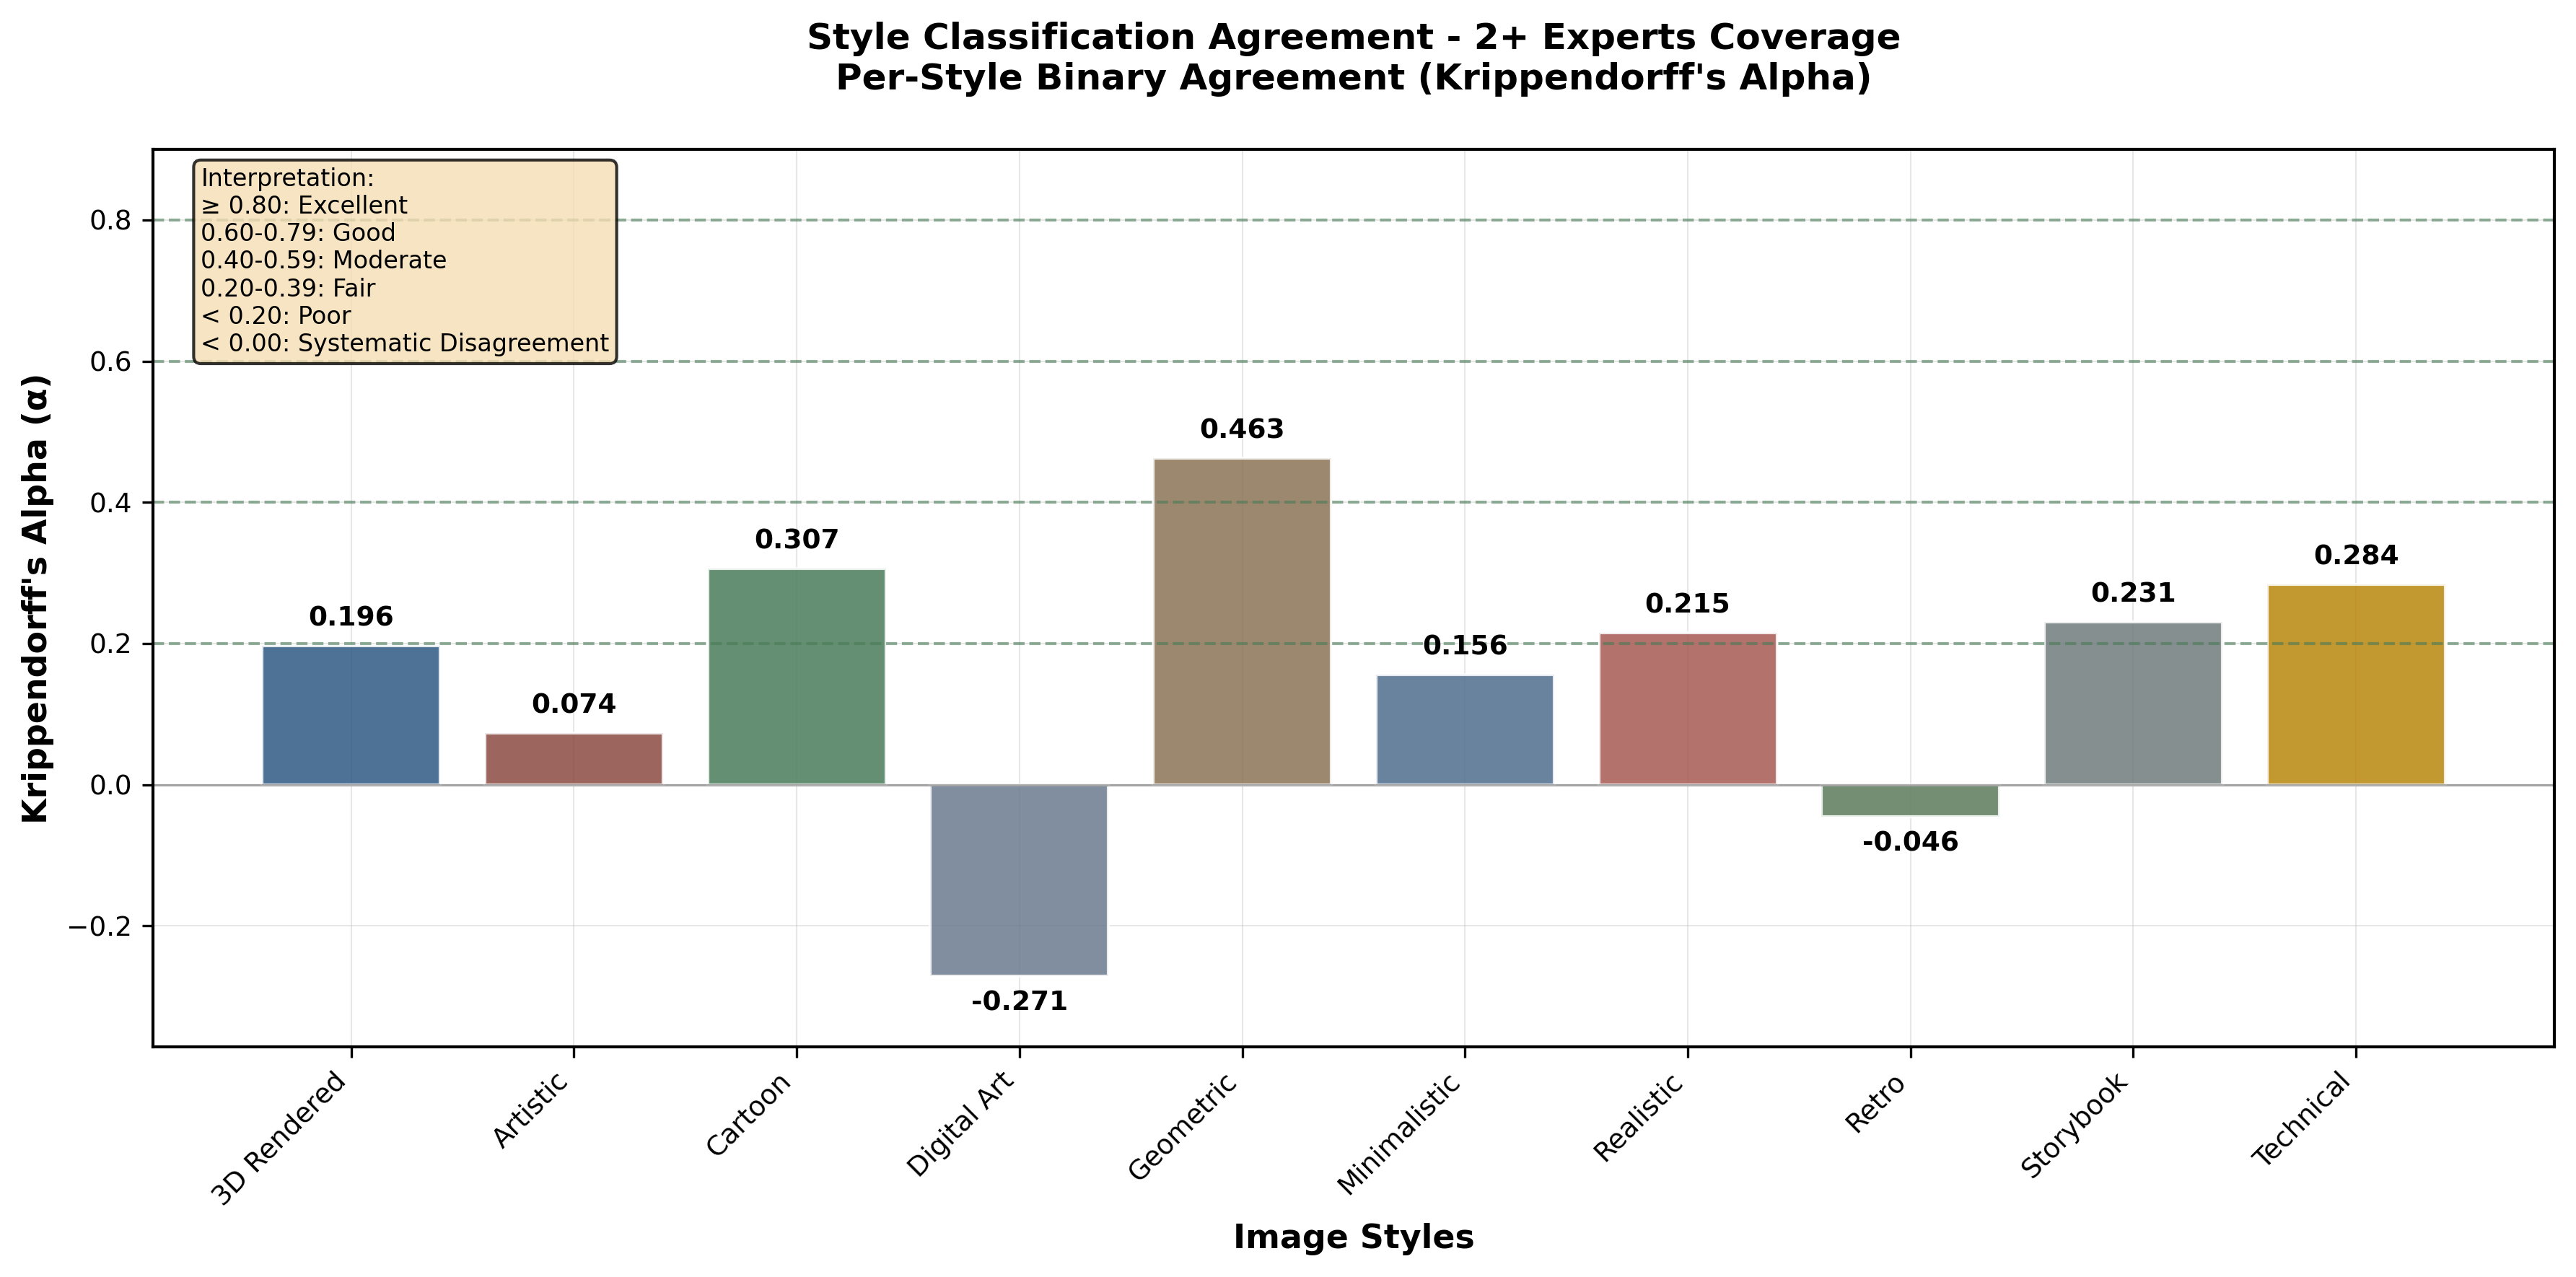

✓ Saved: style_classification_agreement_3+_experts.png


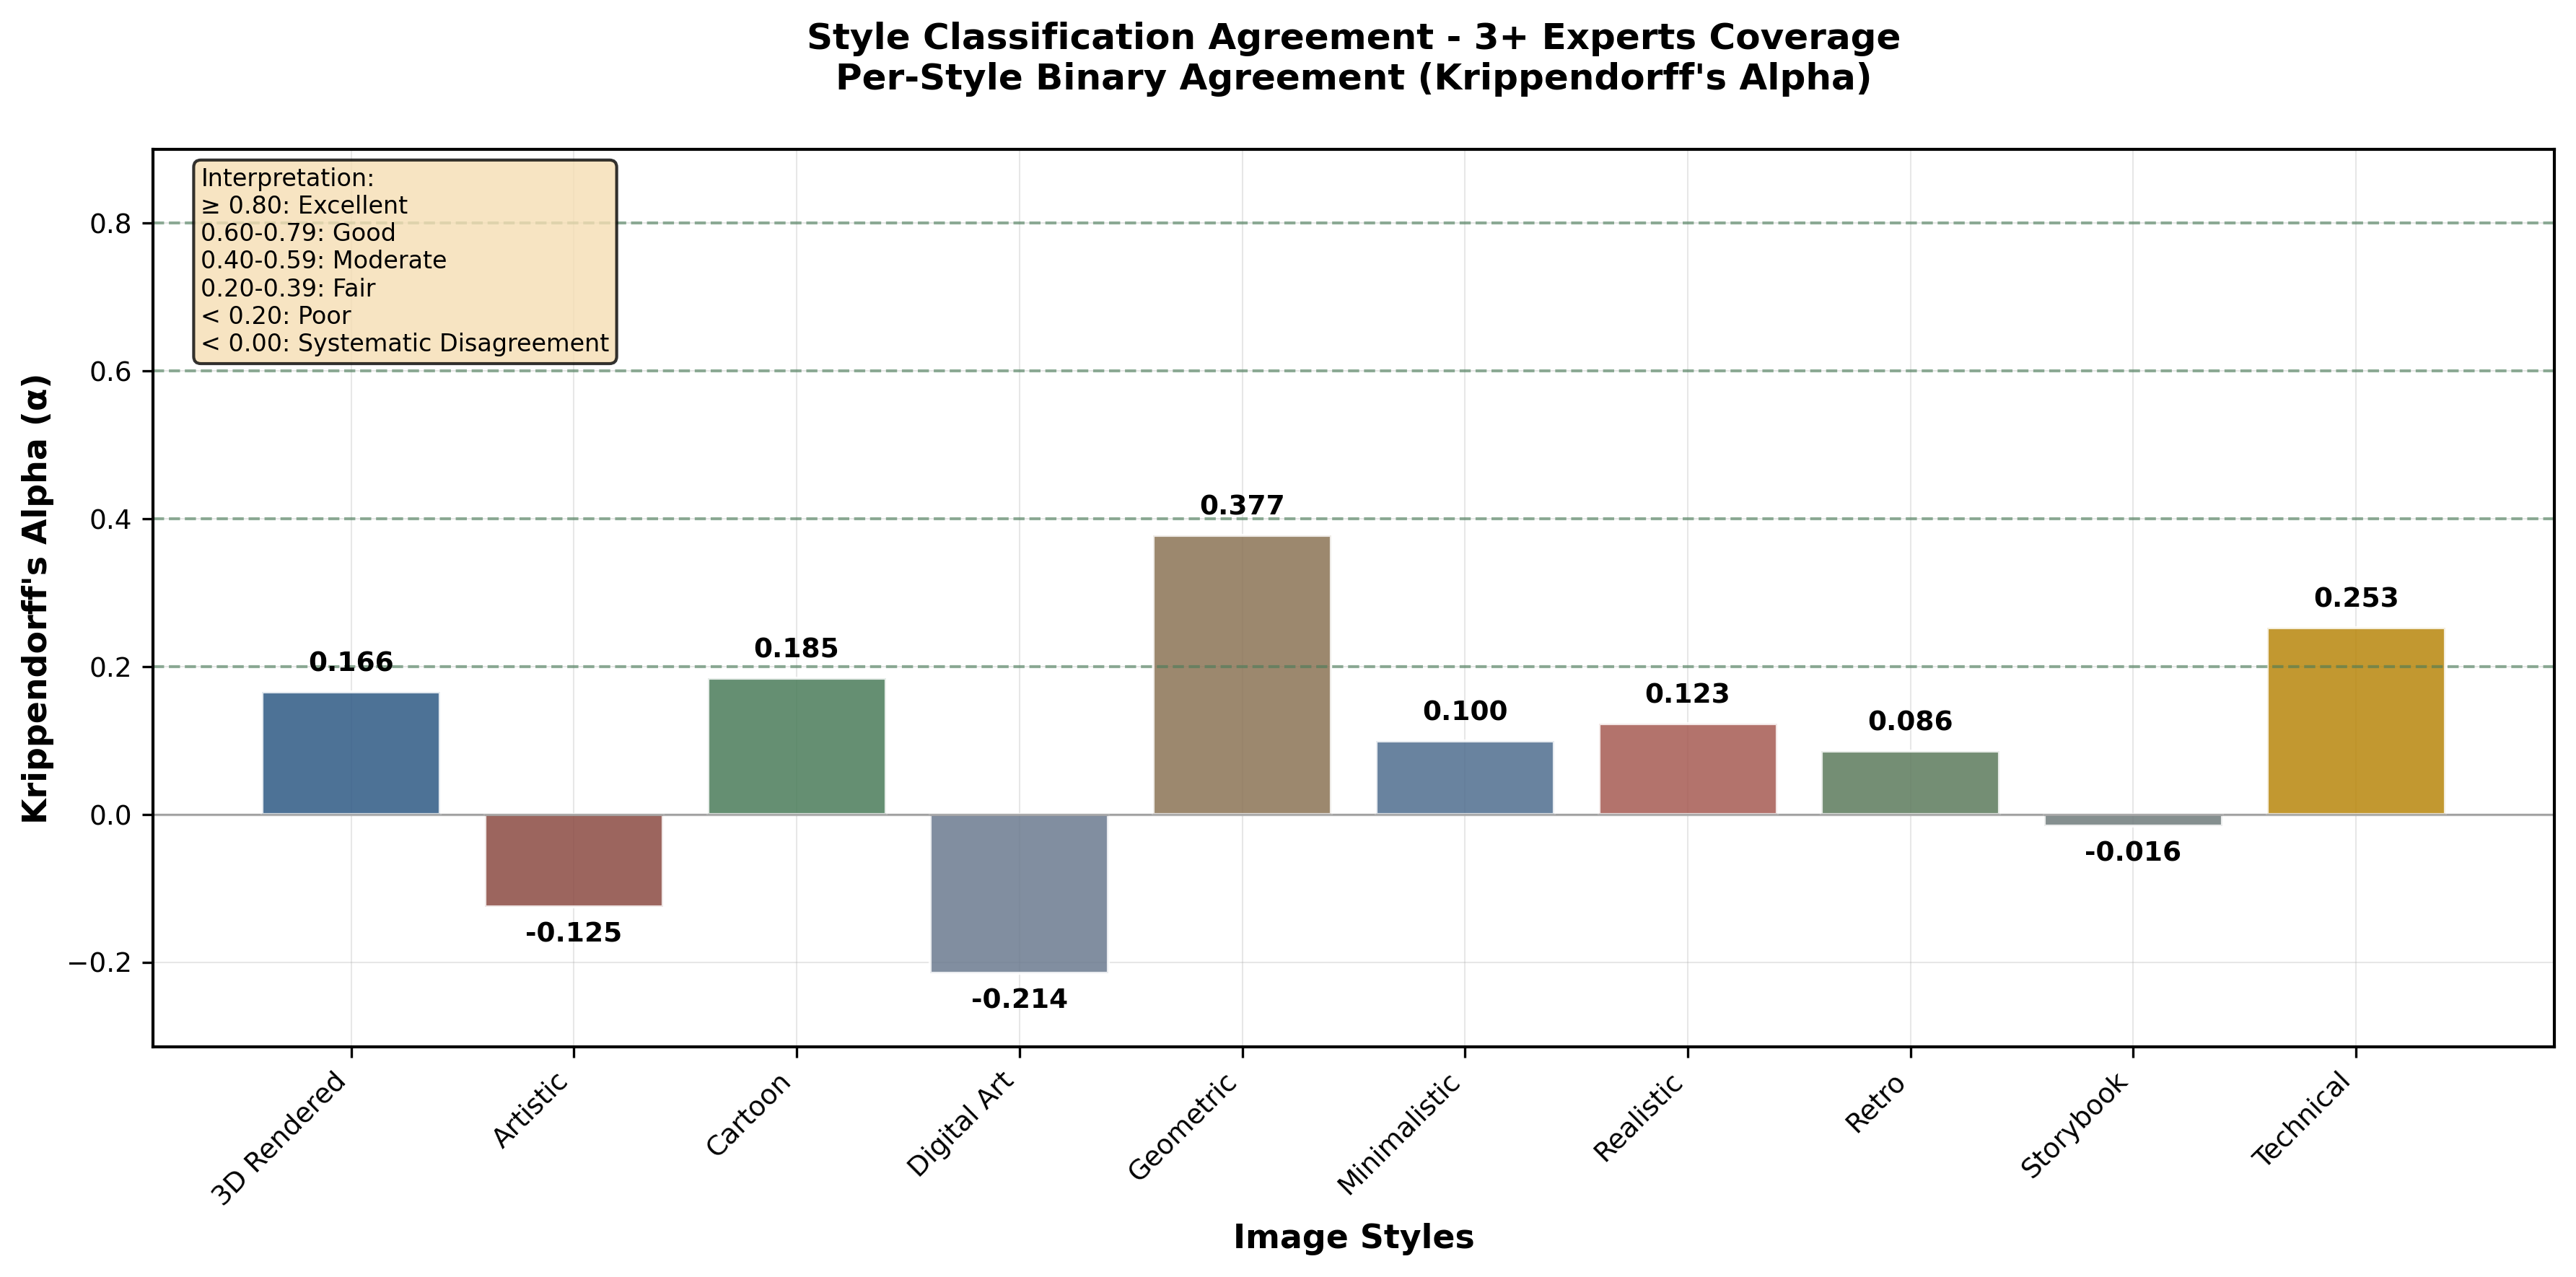

✓ Saved: style_classification_agreement_4_experts.png


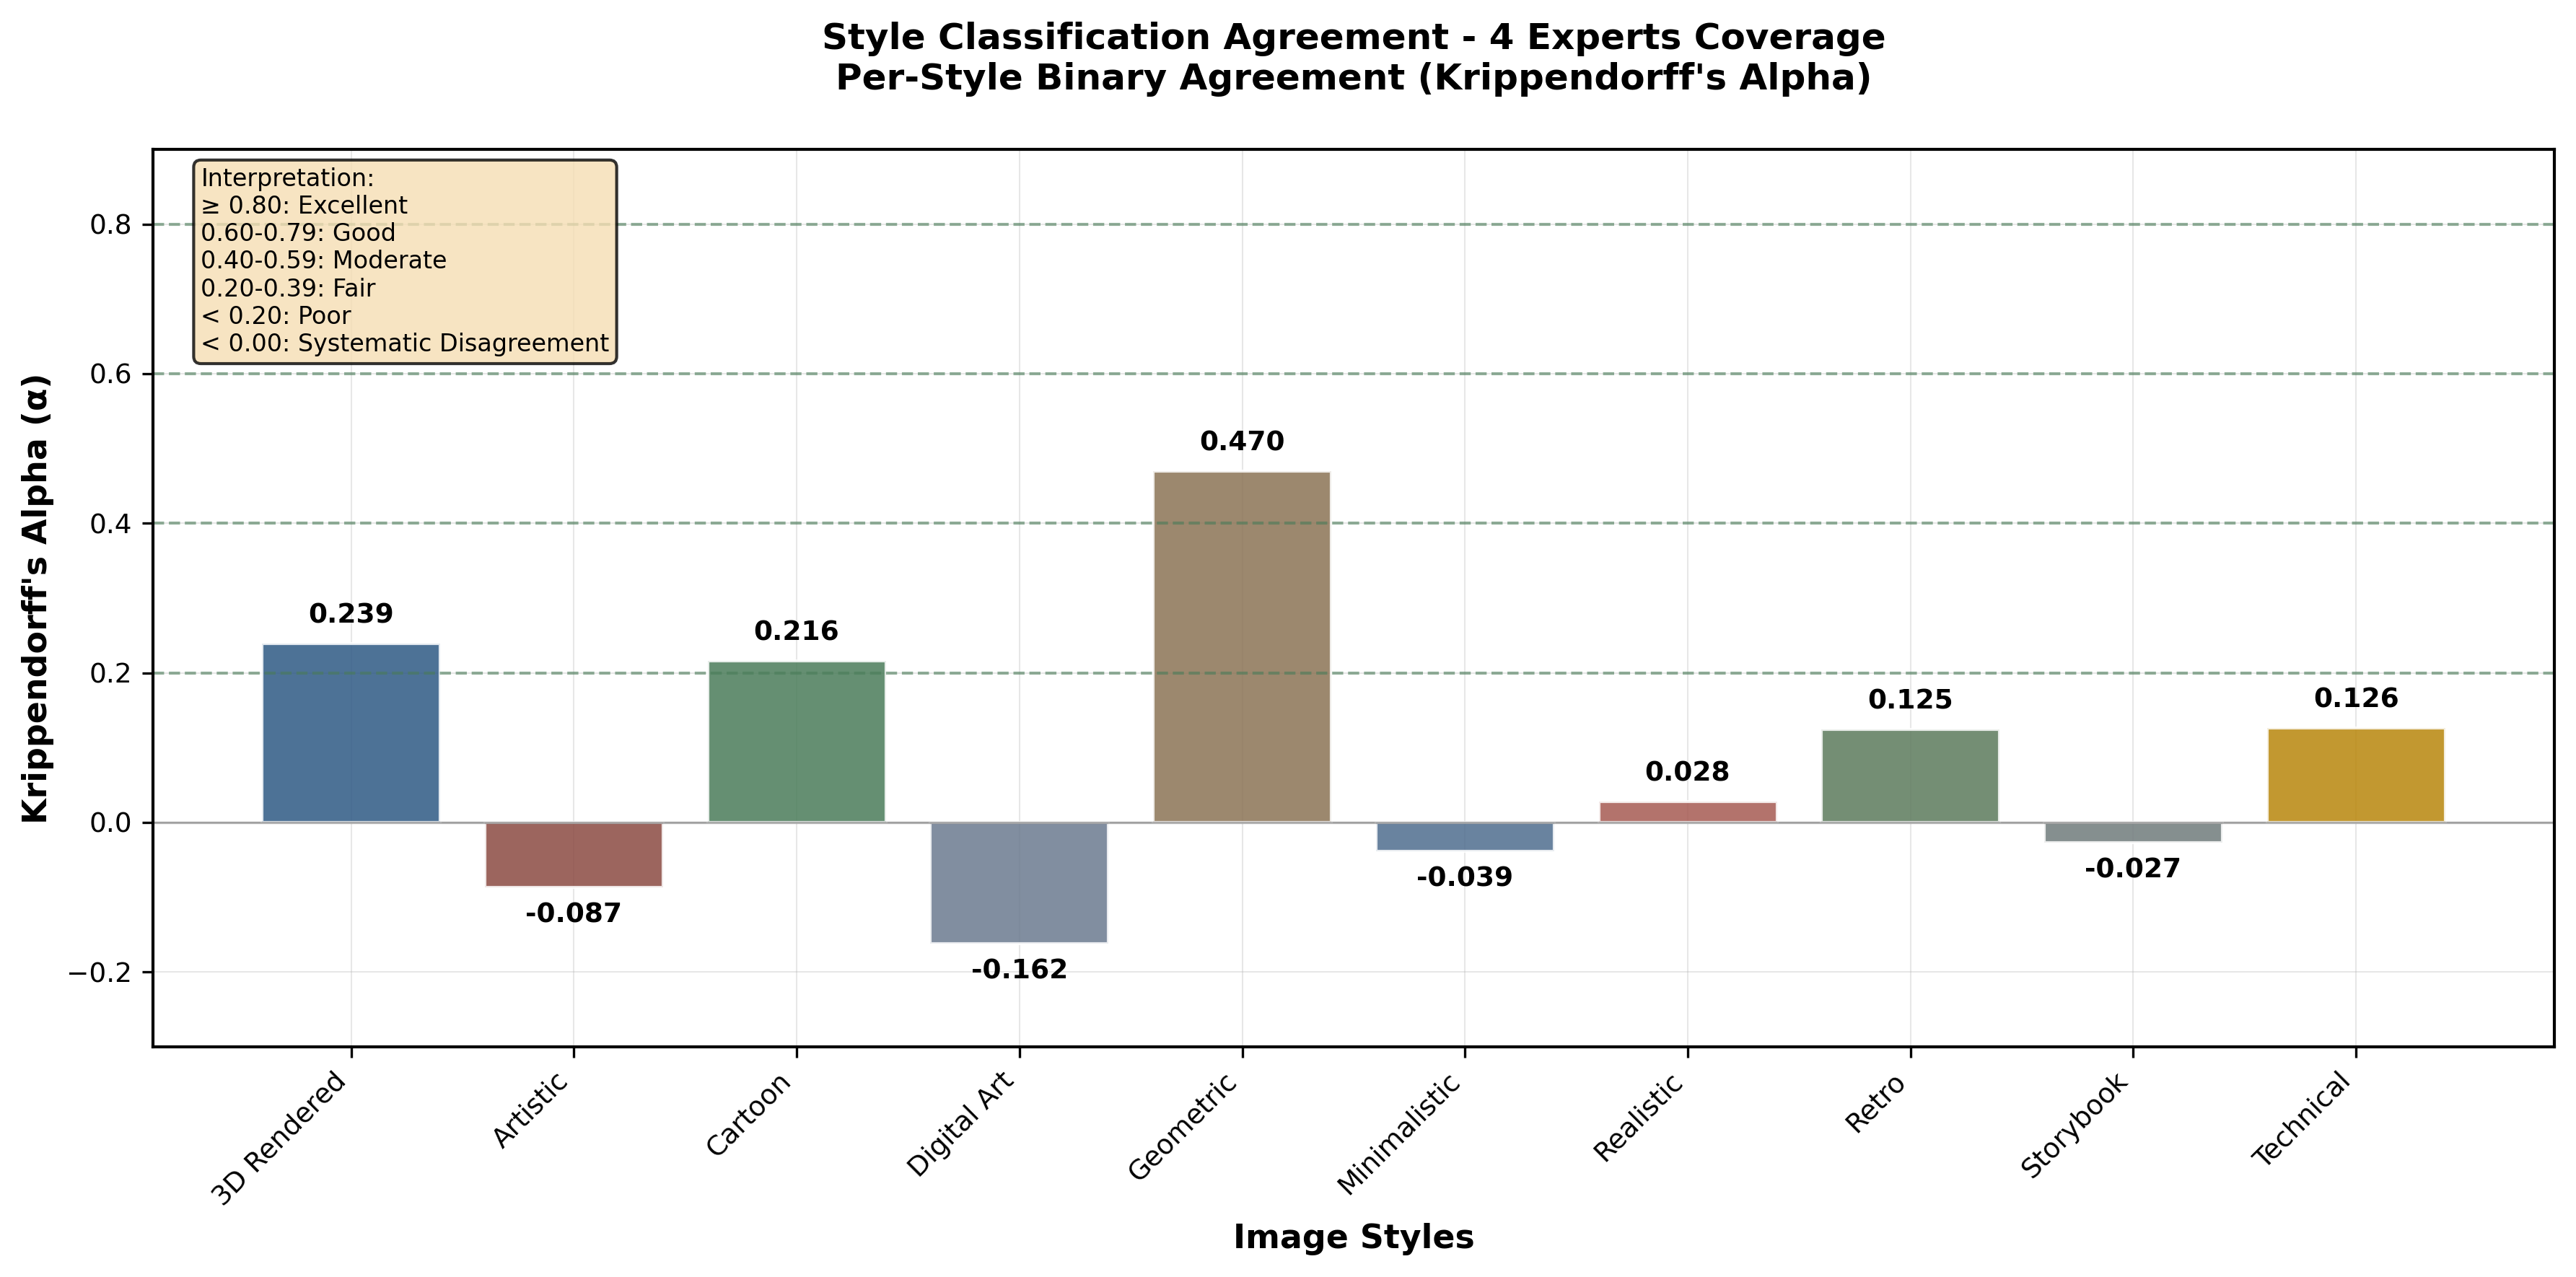


INTERPRETATION 2: RATING AGREEMENT BY STYLE
CREATING INTERPRETATION 2 BAR CHARTS: RATING AGREEMENT BY STYLE
Processing 2+ Experts Coverage...
✓ Saved: rating_agreement_by_style_2+_experts.png


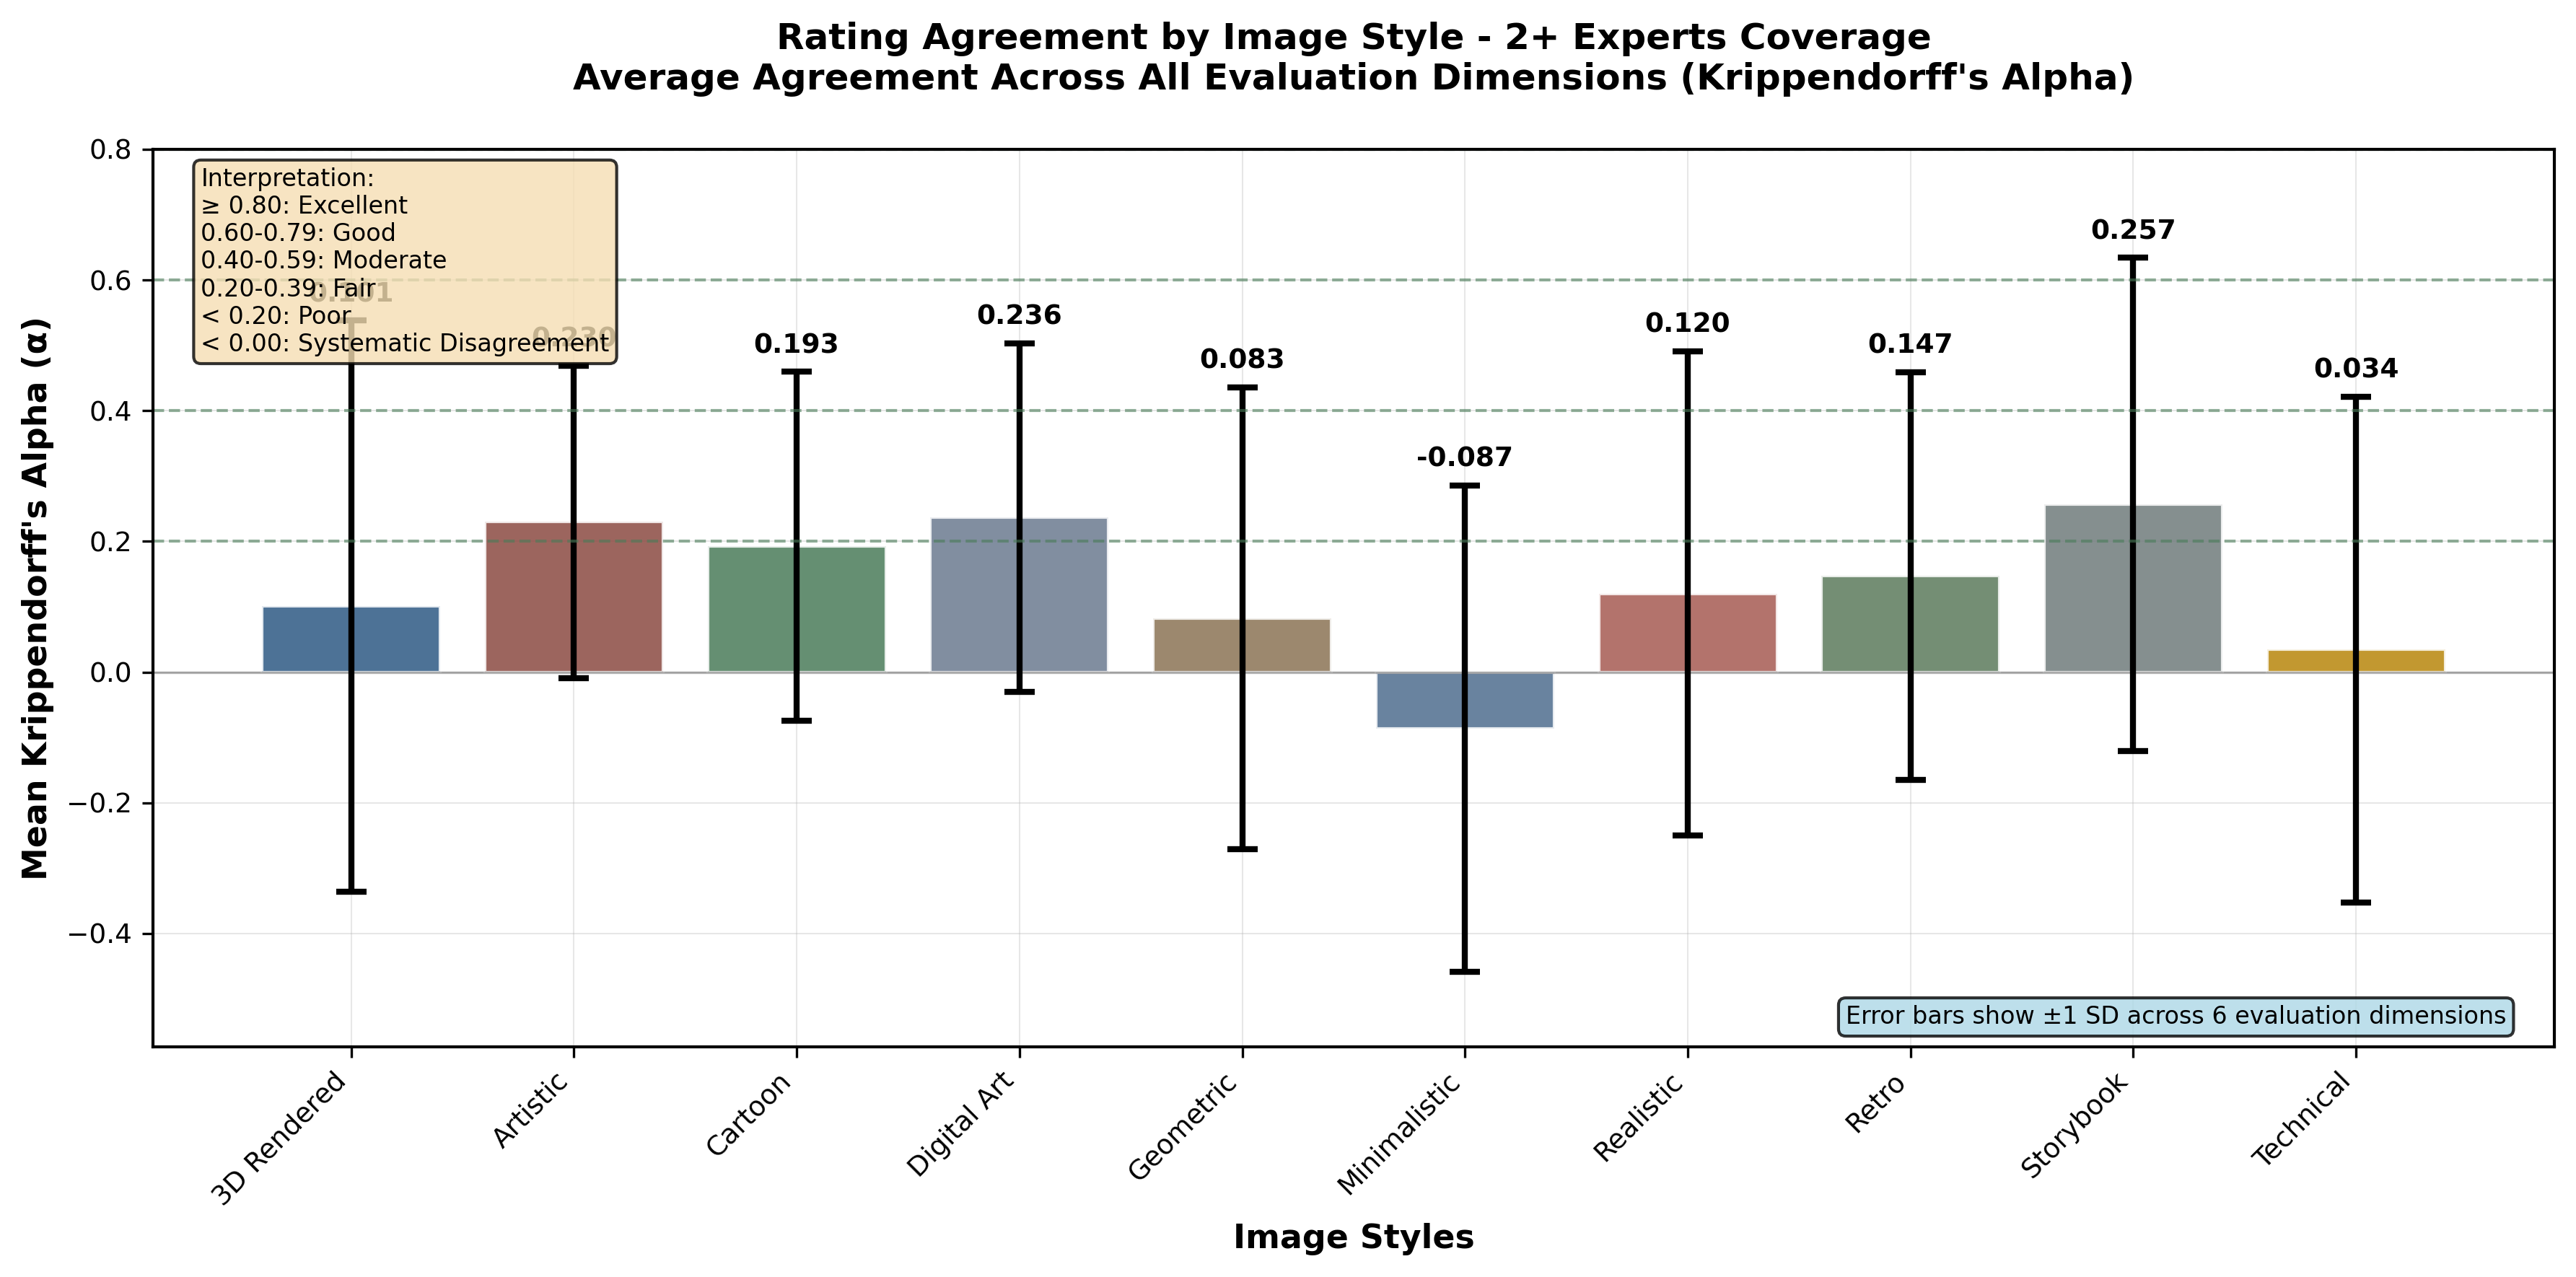

Processing 3+ Experts Coverage...
✓ Saved: rating_agreement_by_style_3+_experts.png


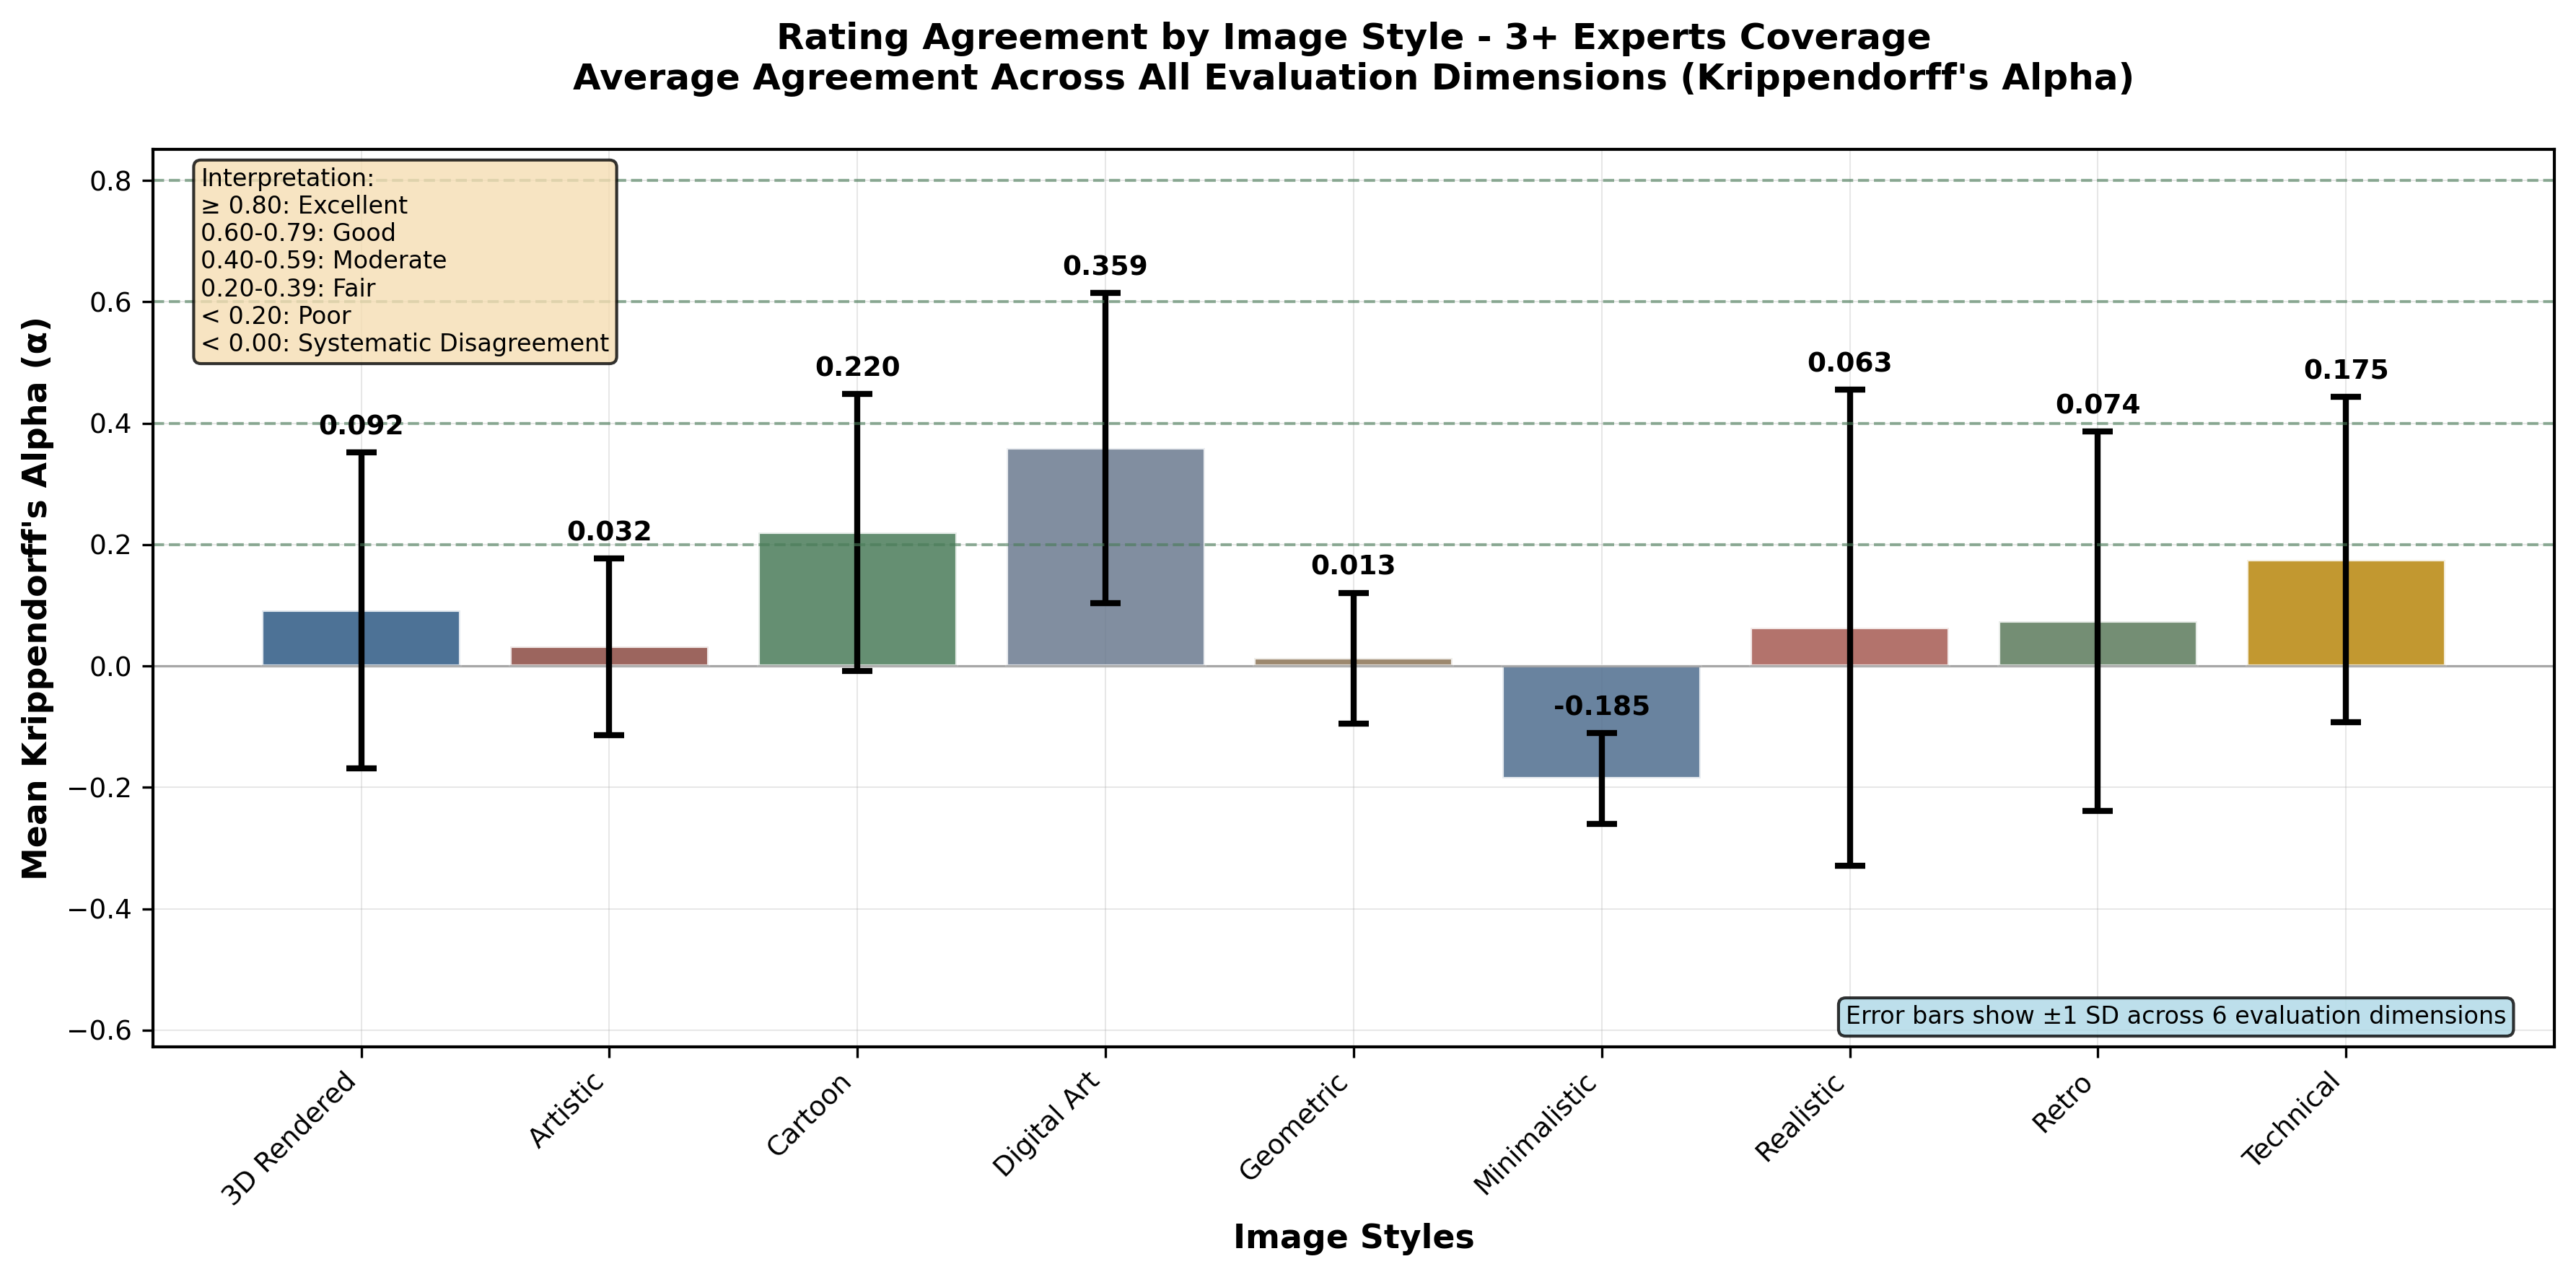

Processing 4 Experts Coverage...
✓ Saved: rating_agreement_by_style_4_experts.png


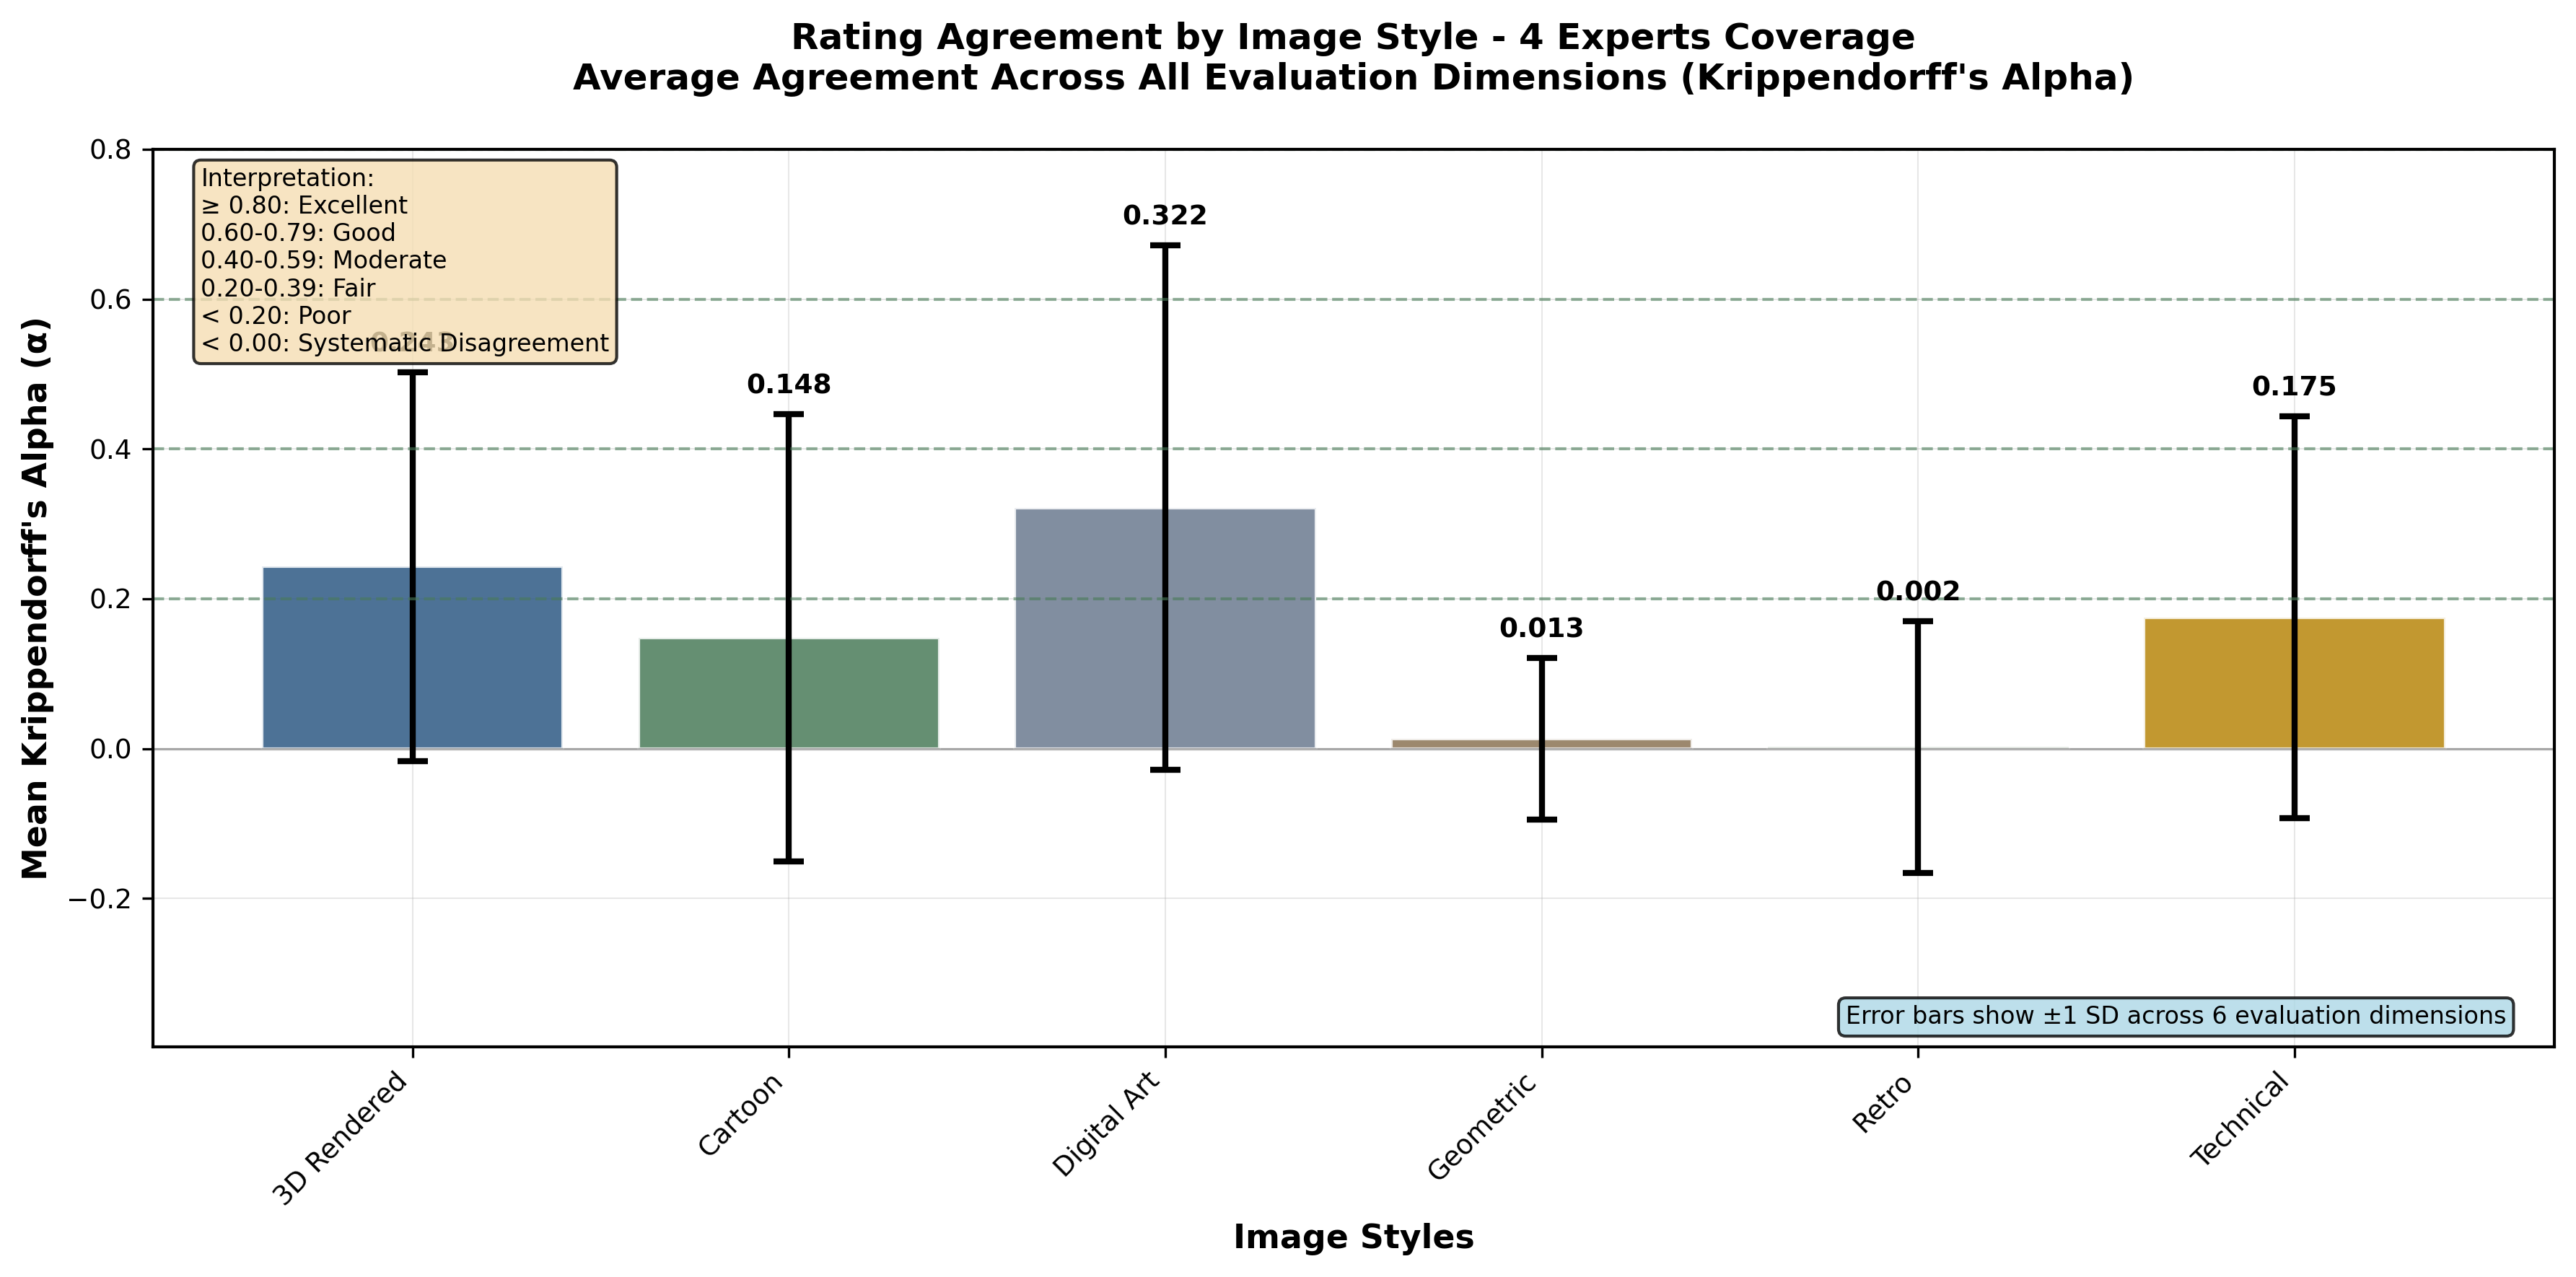


ALL BAR CHARTS CREATED SUCCESSFULLY!
Generated files:
Interpretation 1 (Style Classification Agreement):
  - style_classification_agreement_2+_experts.png
  - style_classification_agreement_3+_experts.png
  - style_classification_agreement_4_experts.png
Interpretation 2 (Rating Agreement by Style):
  - rating_agreement_by_style_2+_experts.png
  - rating_agreement_by_style_3+_experts.png
  - rating_agreement_by_style_4_experts.png


In [21]:
# Create all 6 bar charts (3 for each interpretation)
create_all_interpretation_barcharts(per_style_results, all_results)

INTERPRETATION 1: Style Classification Agreement


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


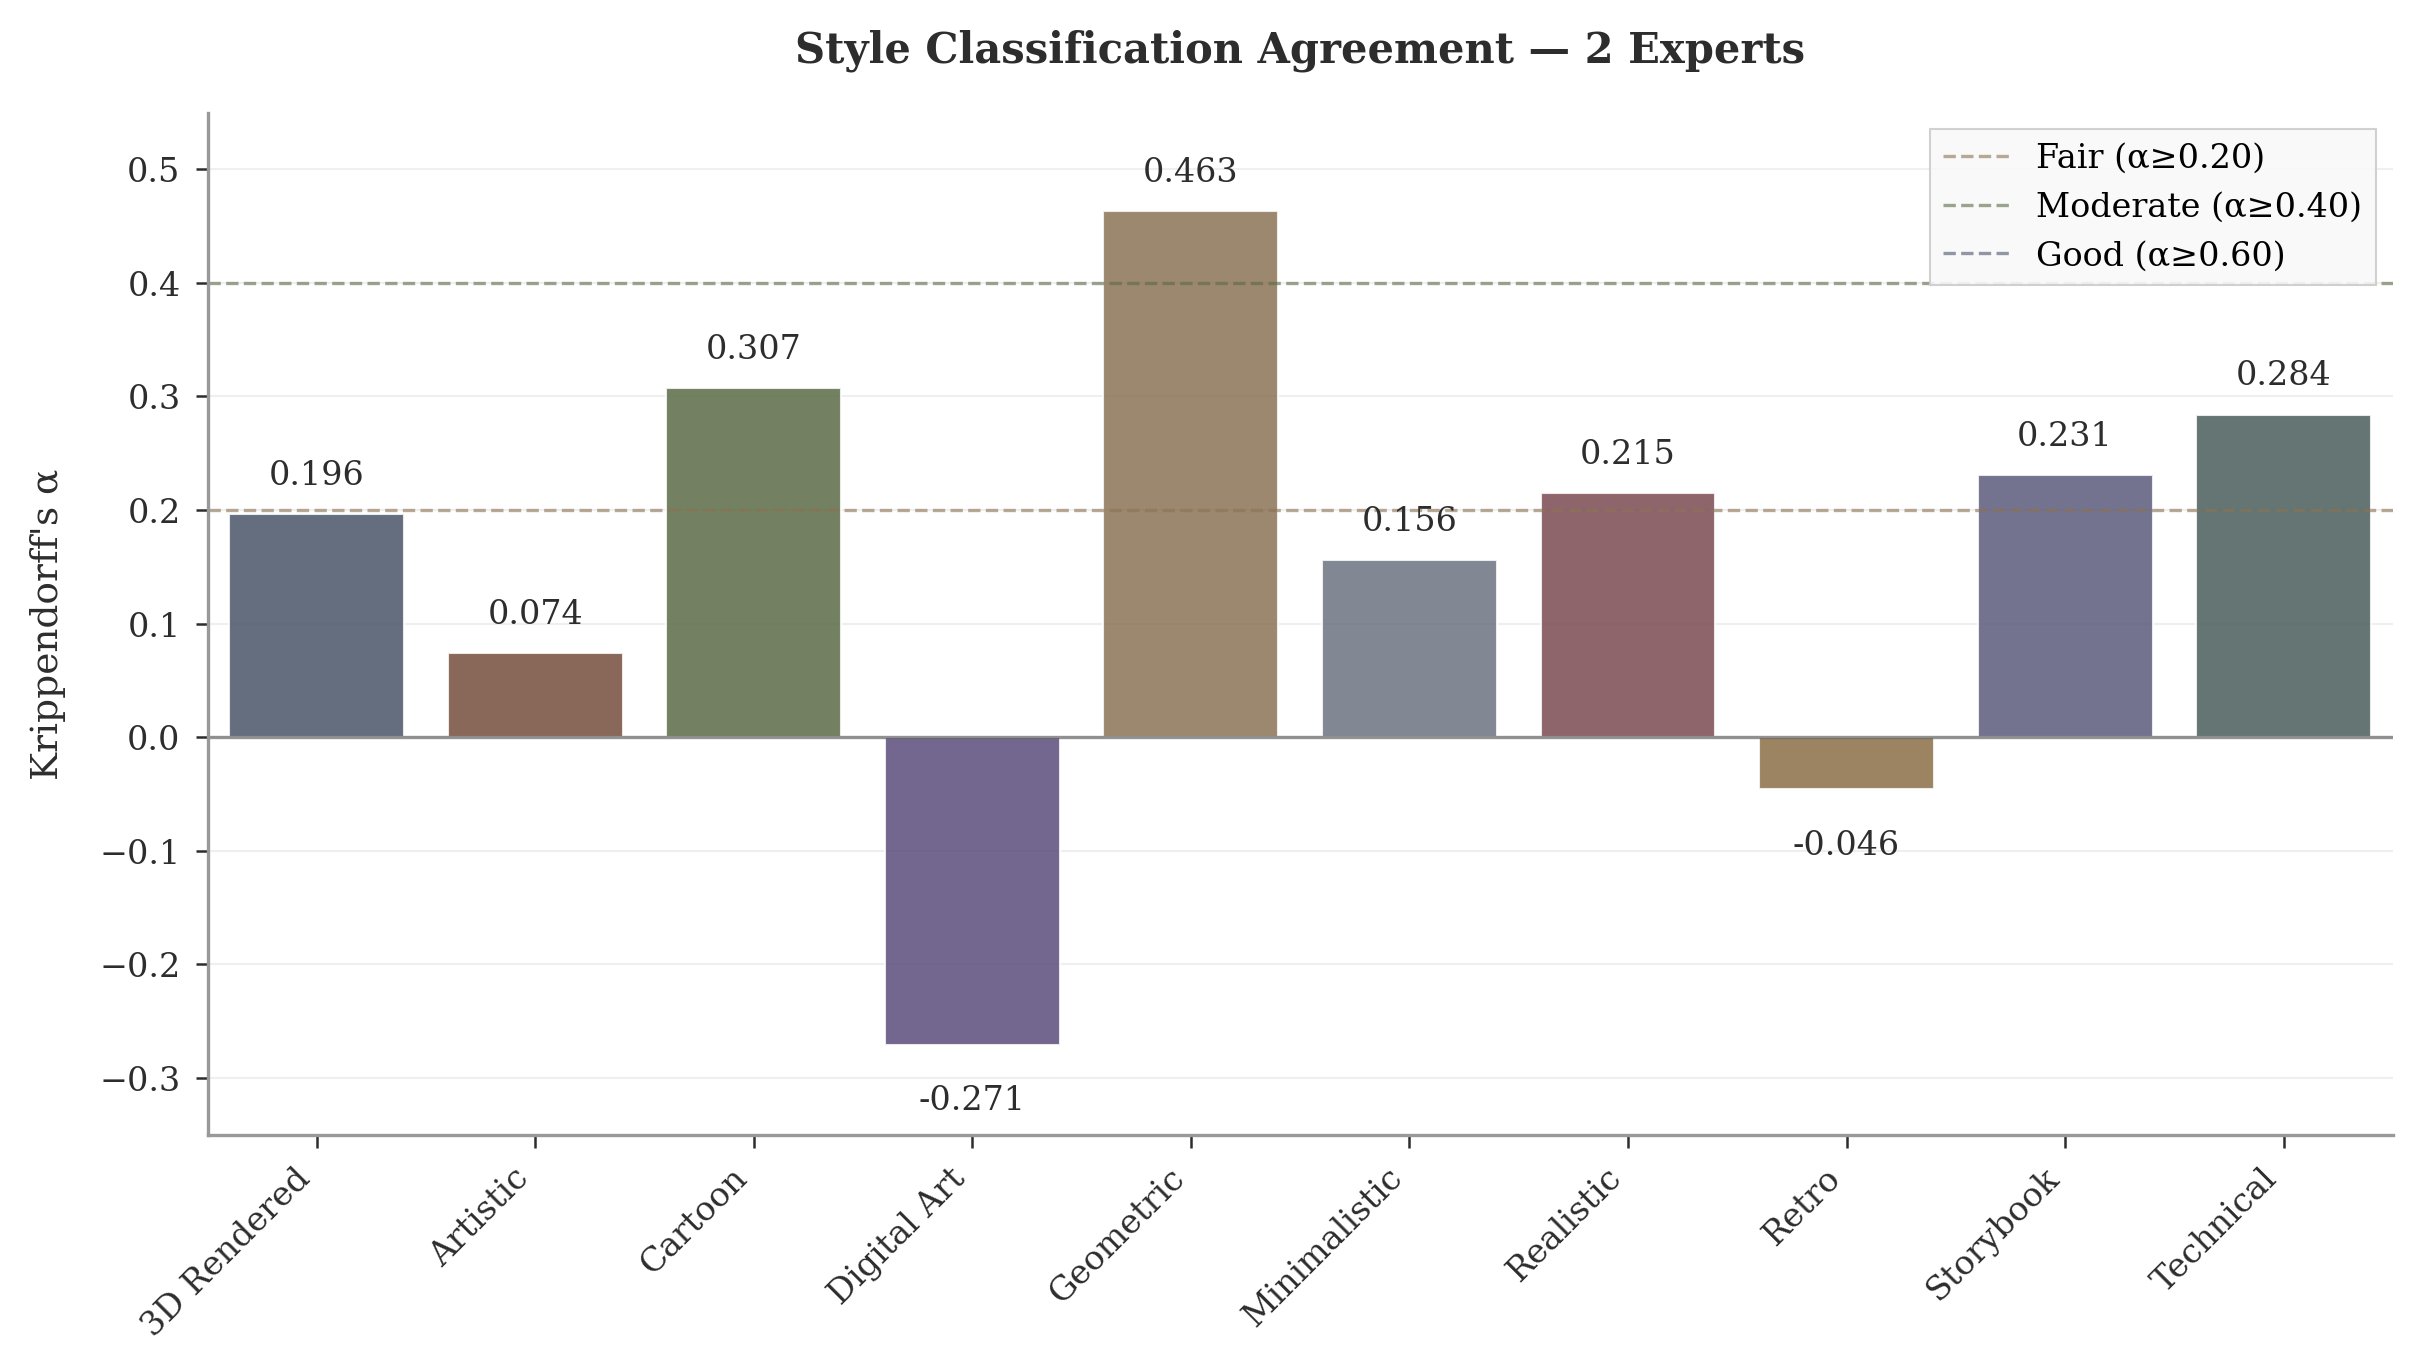

Compact chart saved: style_class_2_experts (PNG/PDF/EPS)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


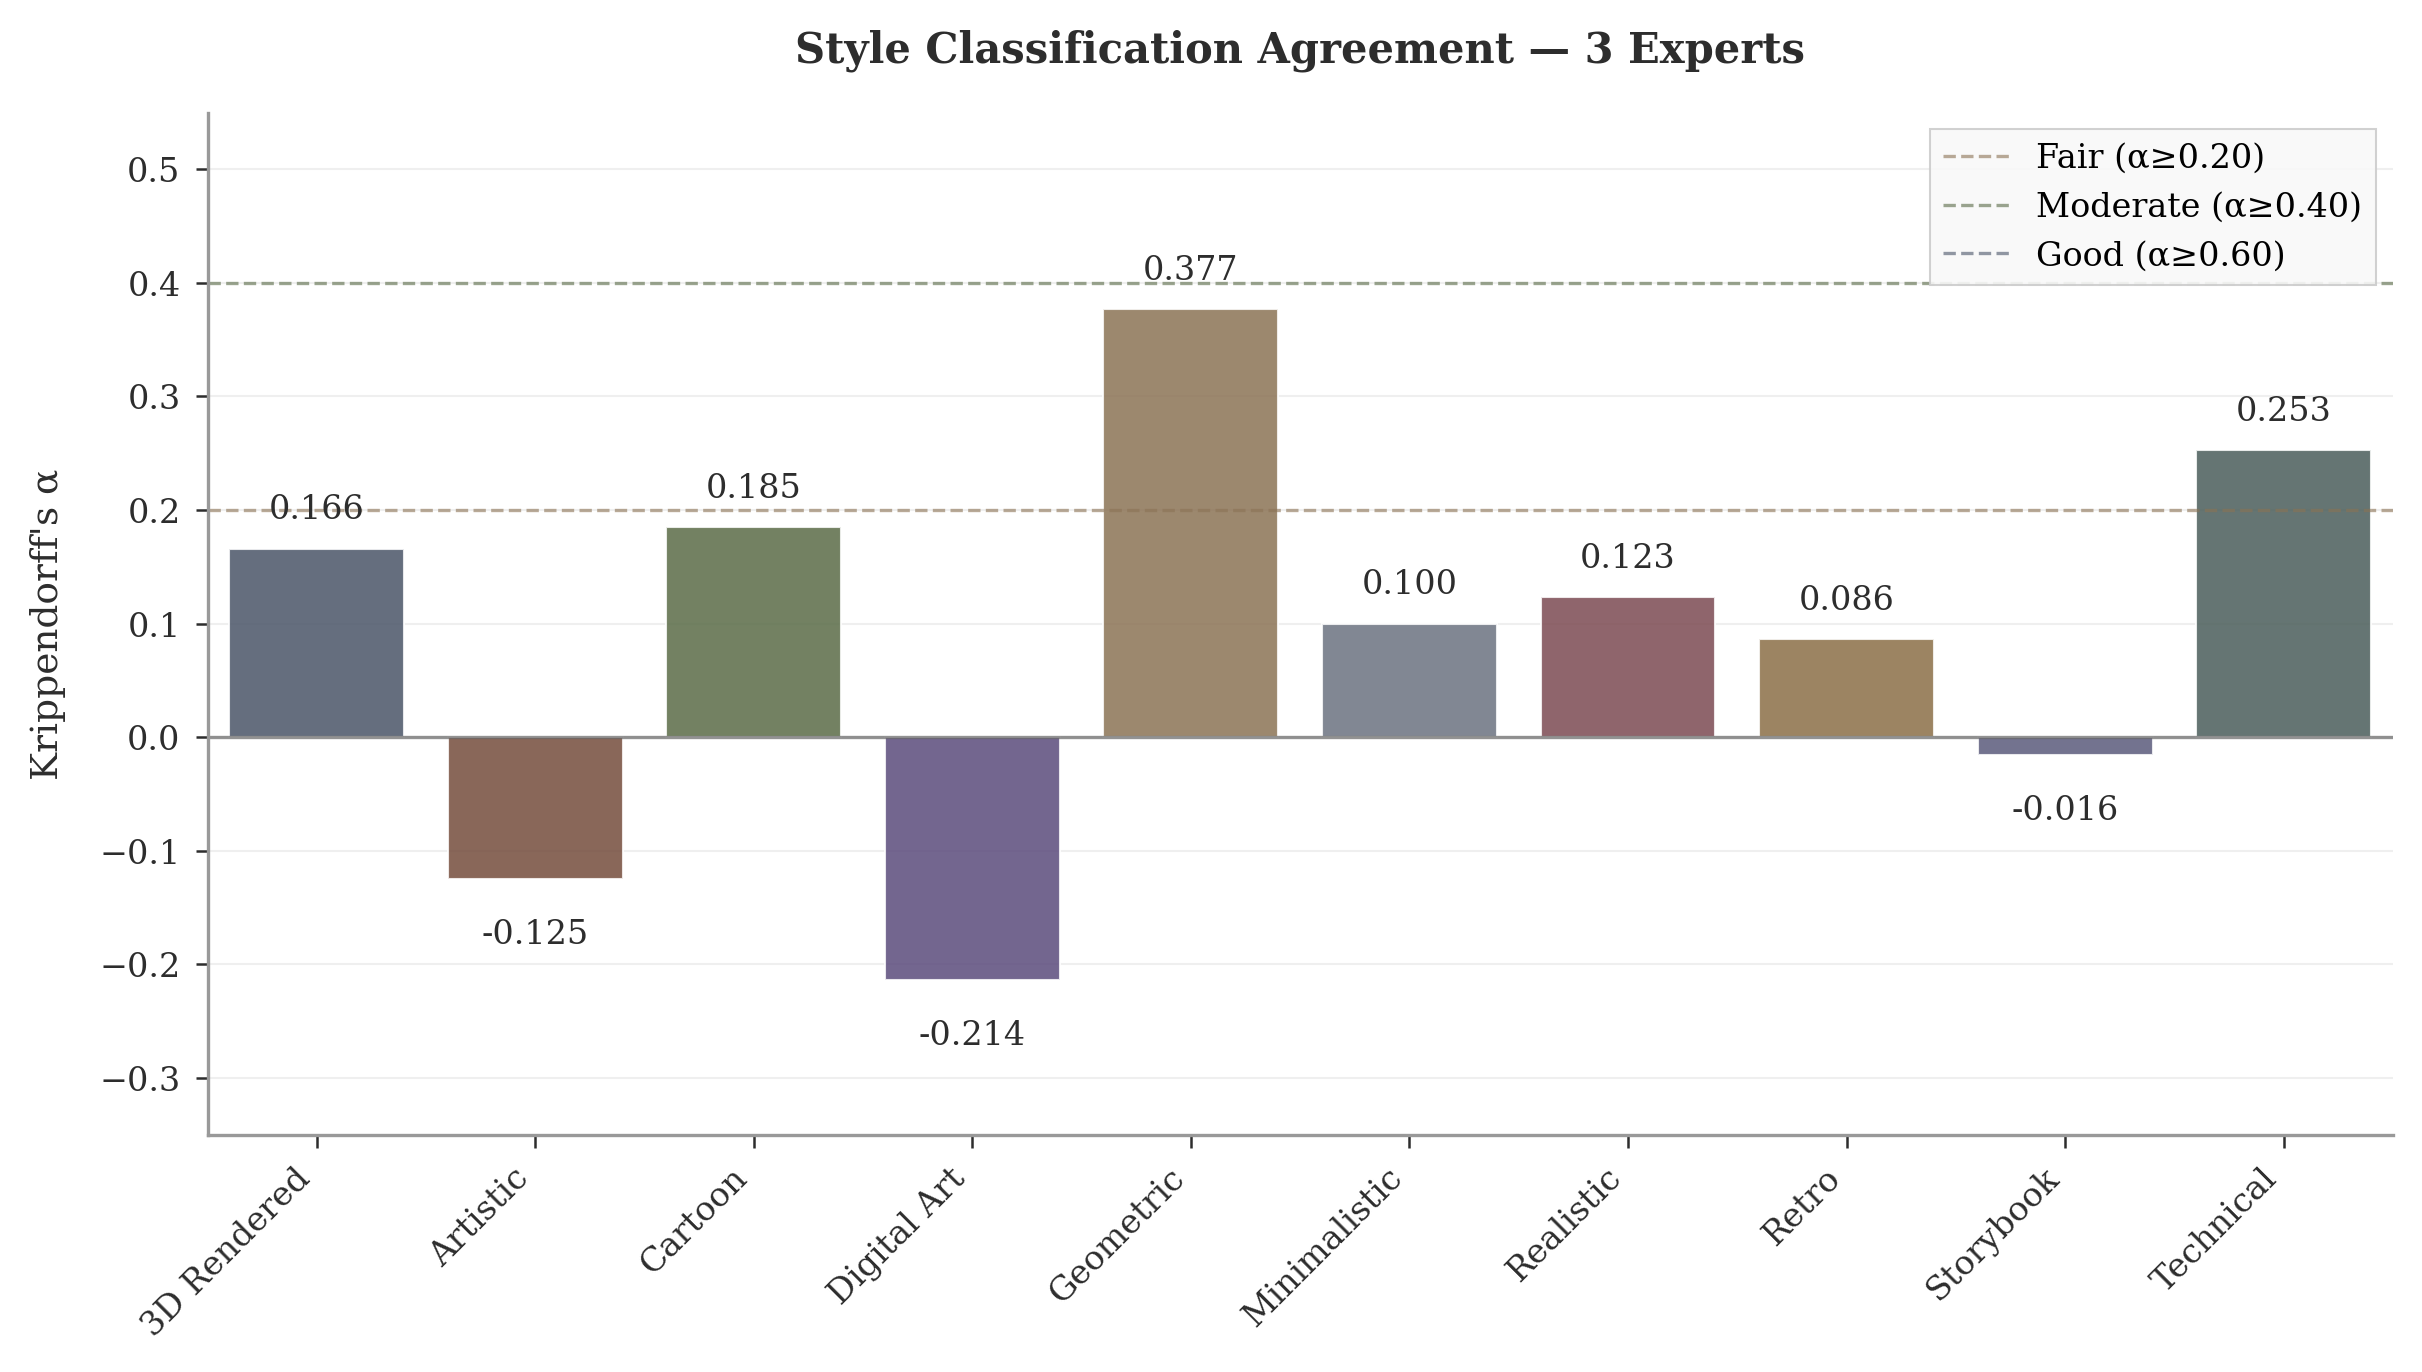

Compact chart saved: style_class_3_experts (PNG/PDF/EPS)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


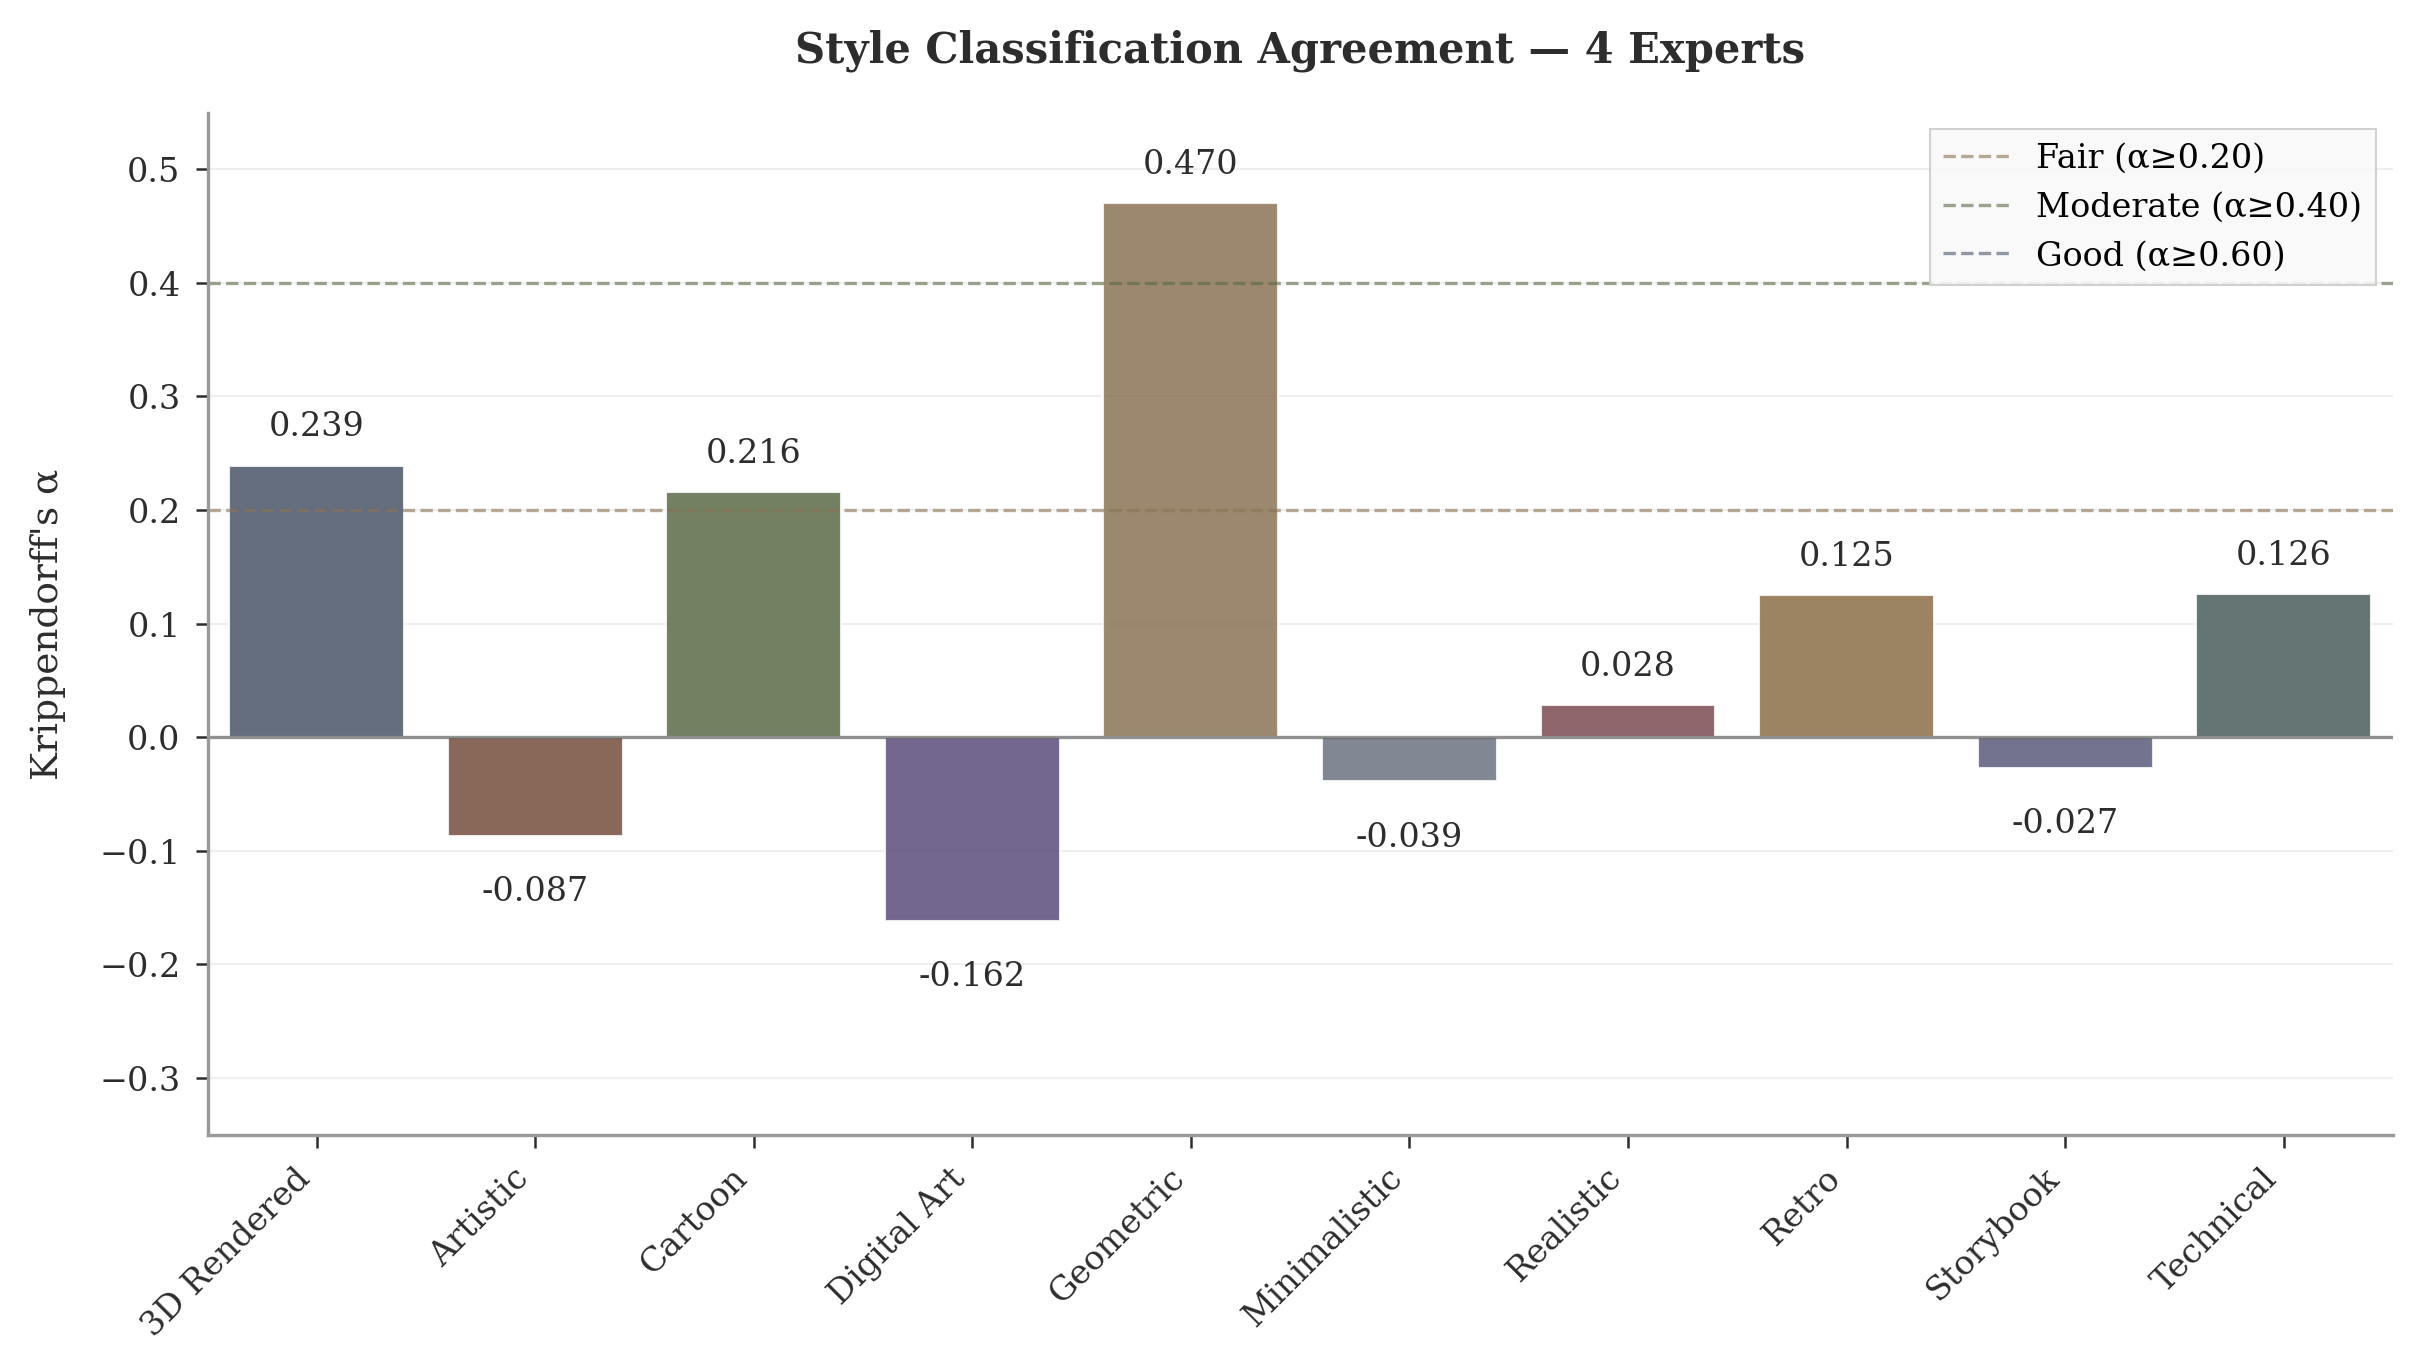

Compact chart saved: style_class_4_experts (PNG/PDF/EPS)

INTERPRETATION 2: Style-Stratified IAA Analysis


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


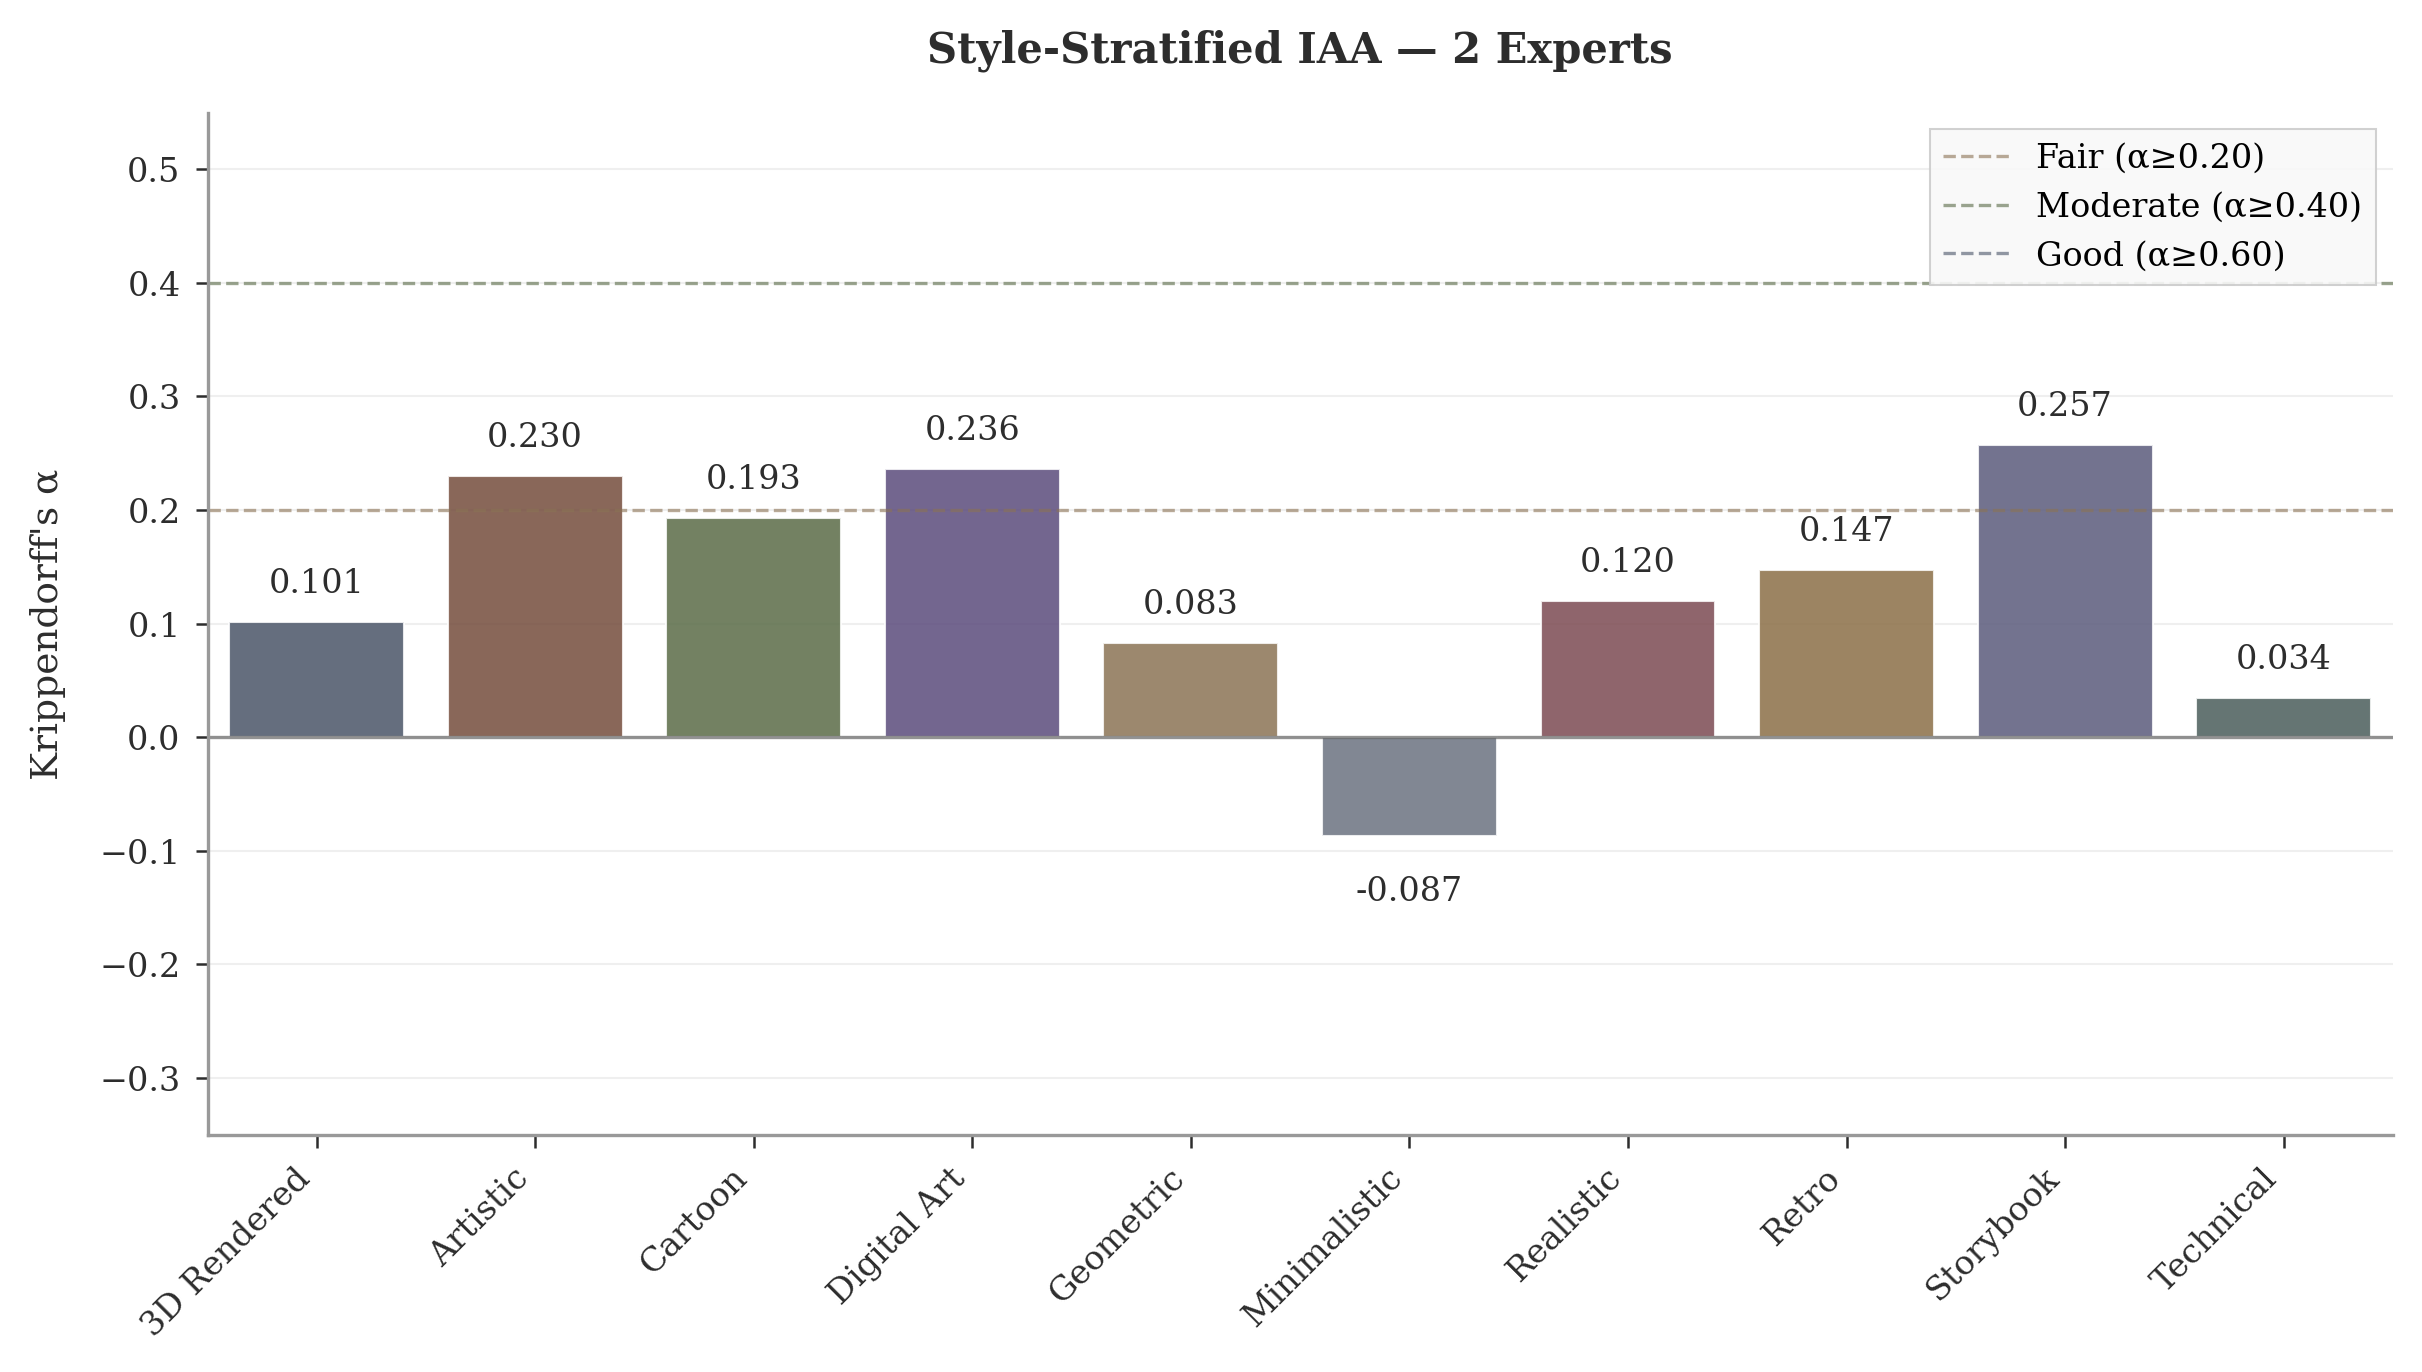

Compact chart saved: style_strat_2_experts (PNG/PDF/EPS)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


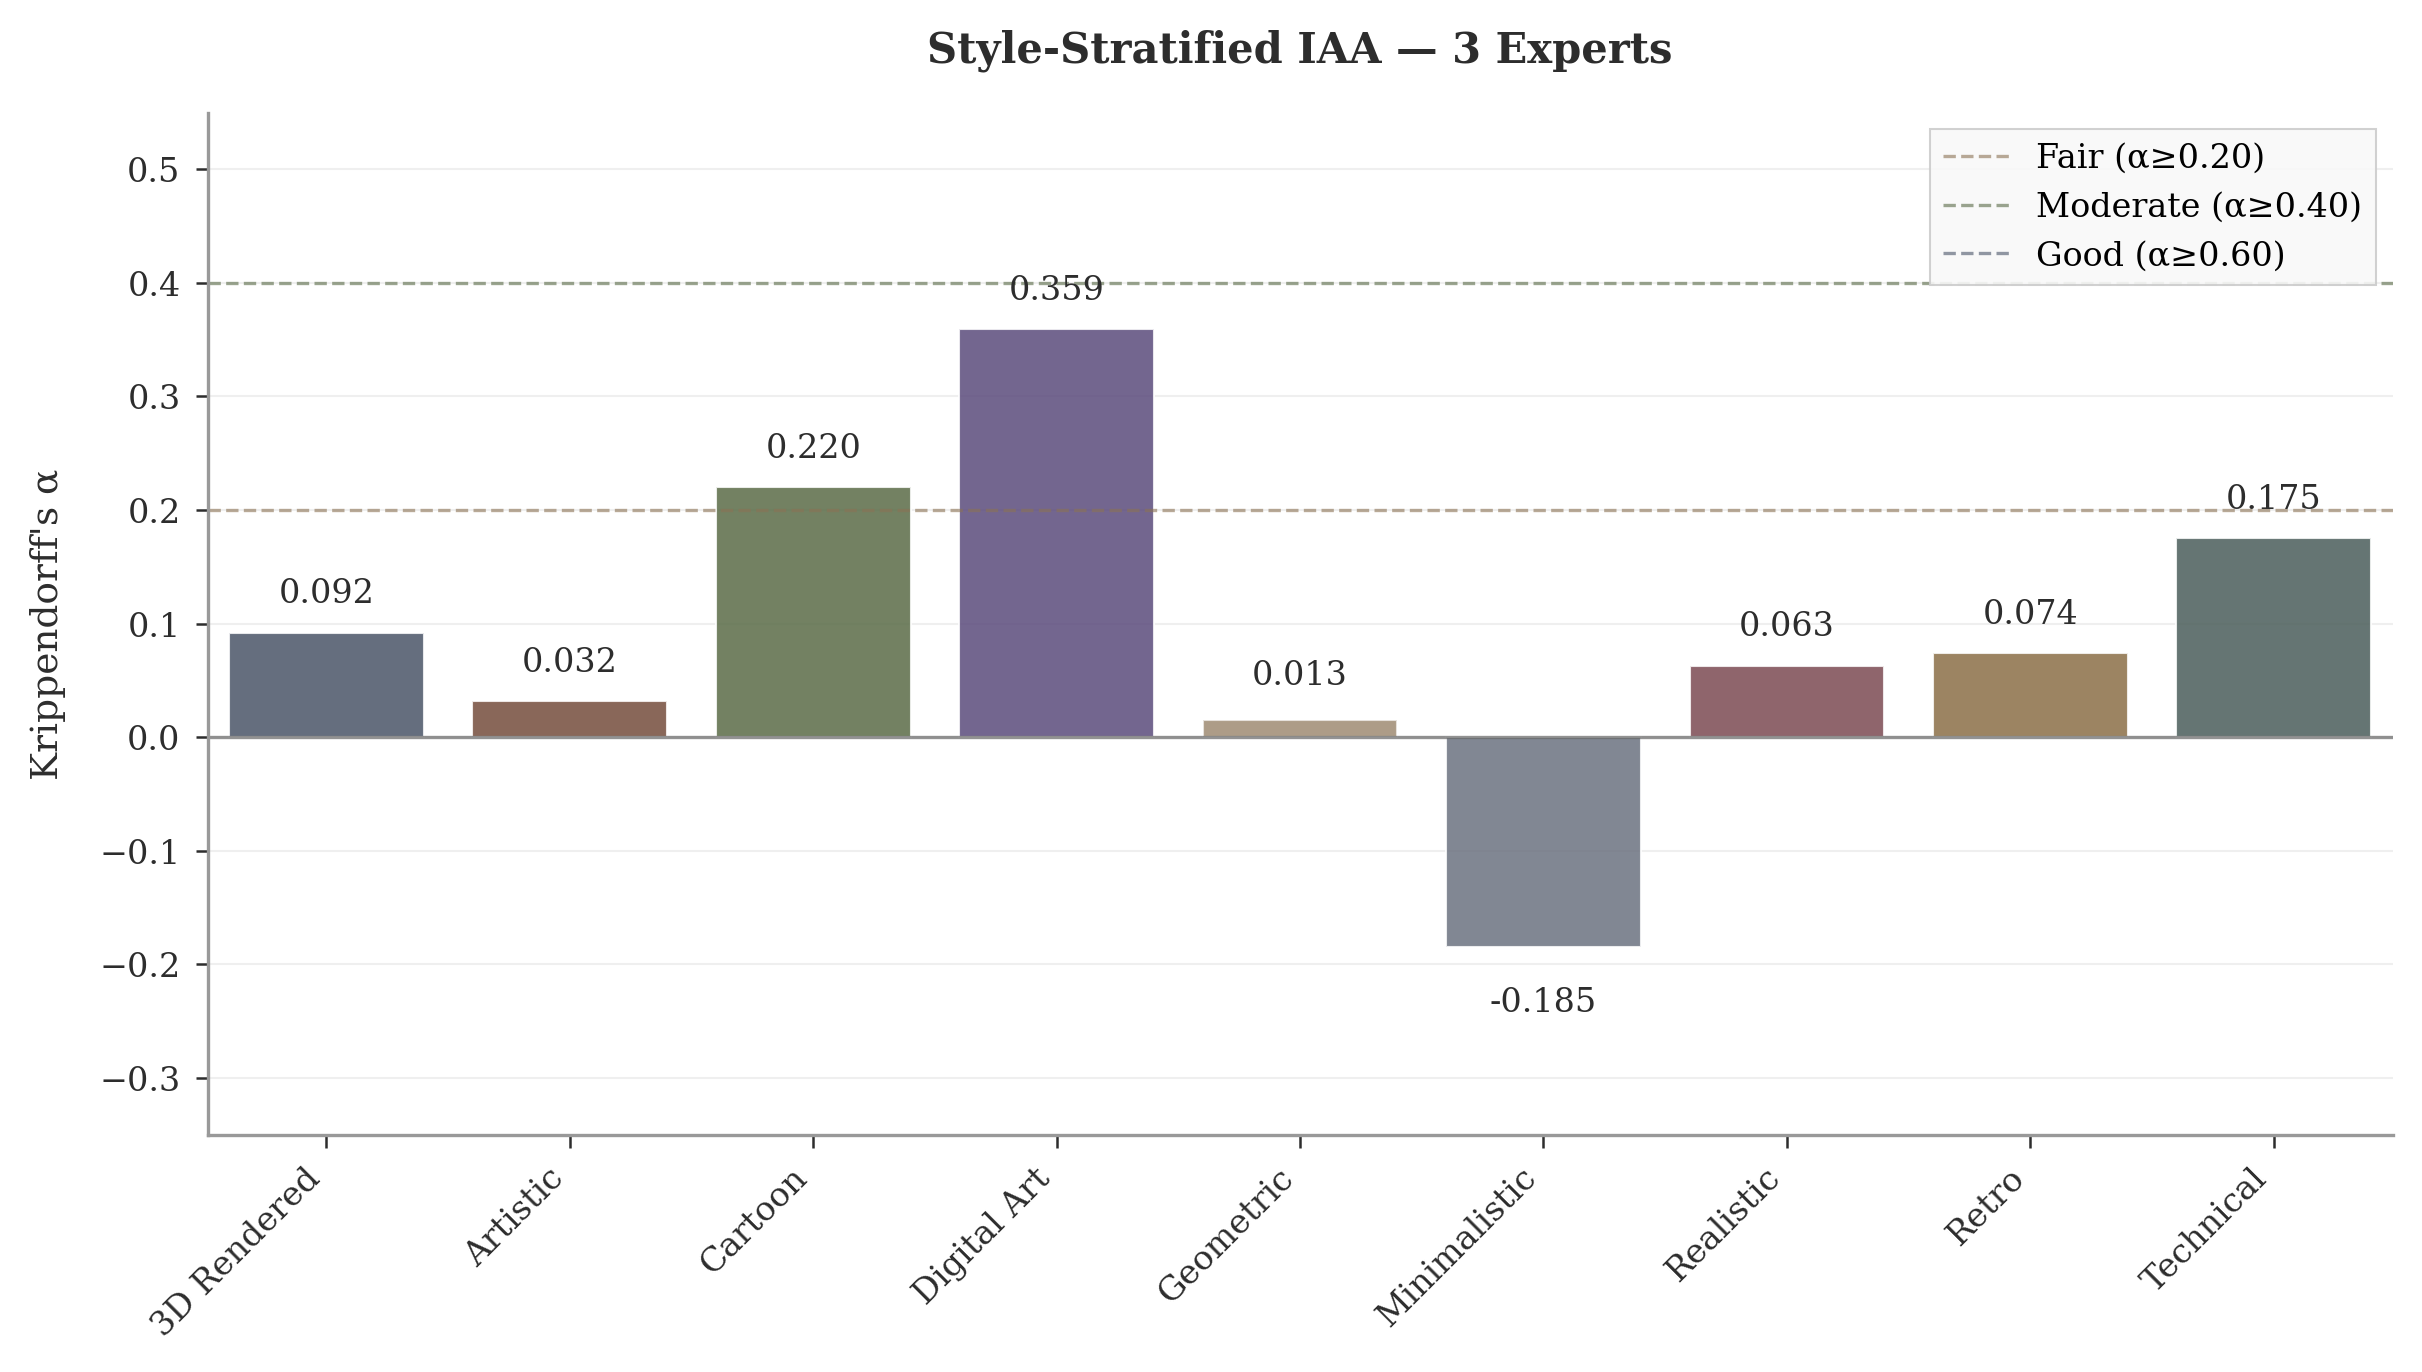

Compact chart saved: style_strat_3_experts (PNG/PDF/EPS)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


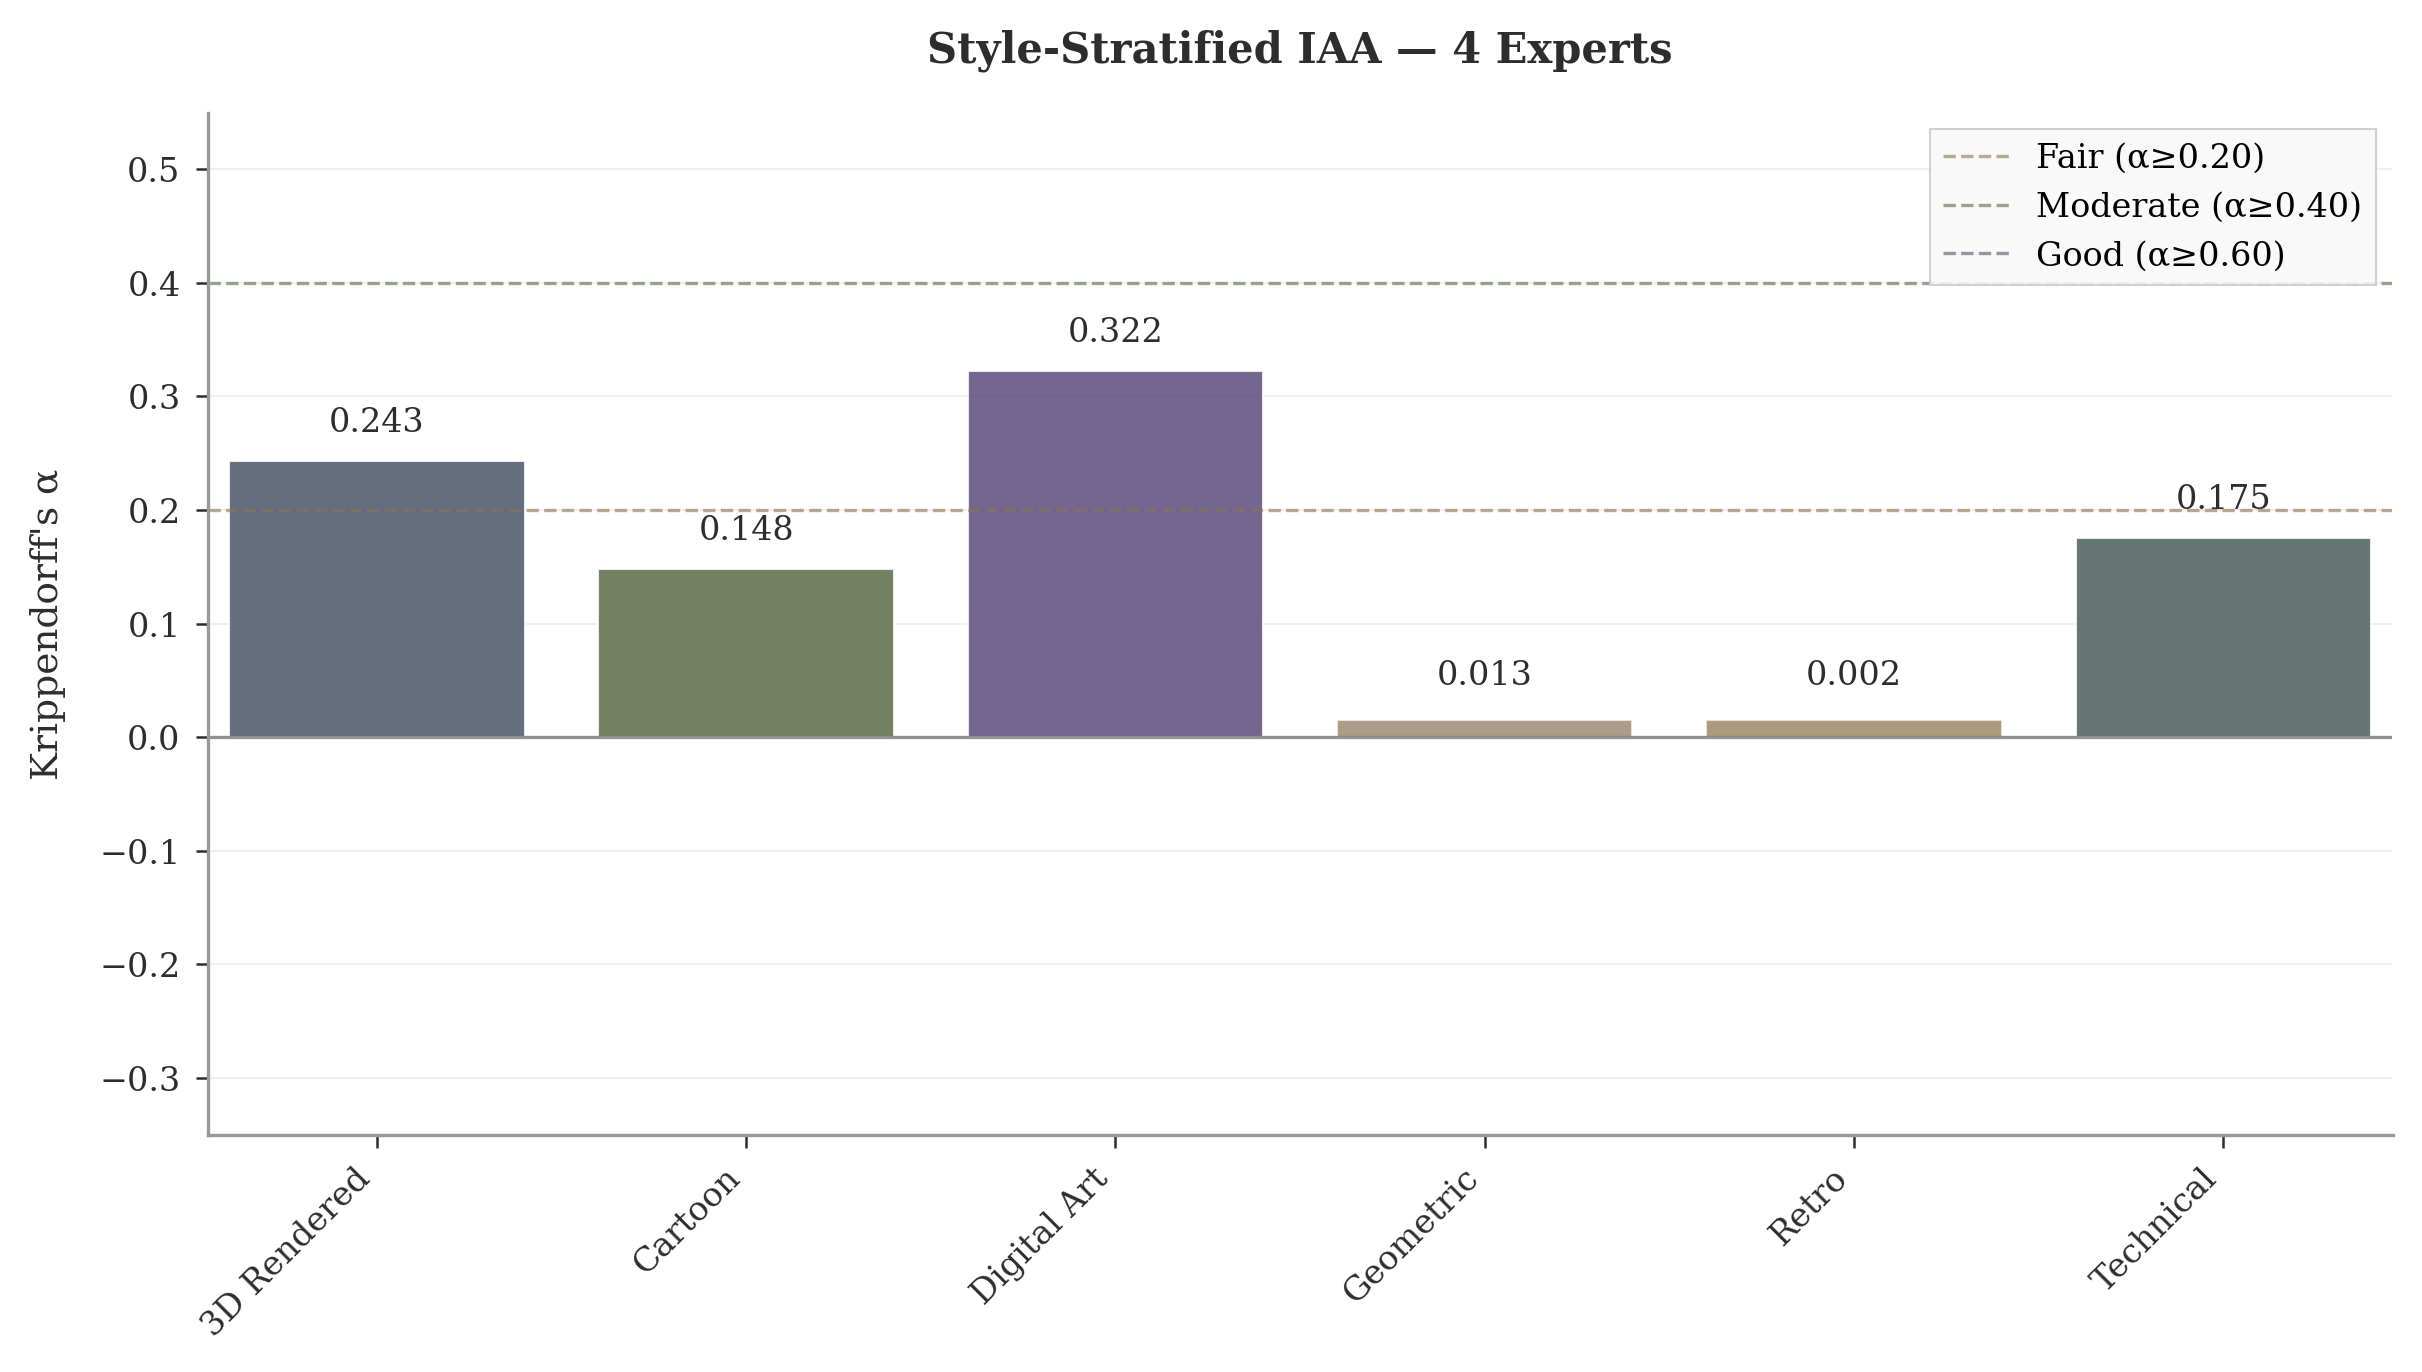

Compact chart saved: style_strat_4_experts (PNG/PDF/EPS)

DESATURATED COLOR SCHEME
Uniform, thesis-appropriate palette:
3D Rendered     #4A5568
Artistic        #744C3C
Cartoon         #5A6B47
Digital Art     #5B4B7C
Geometric       #8B7355
Minimalistic    #6B7280
Realistic       #7C4A52
Retro           #8B6F47
Storybook       #5B5B7C
Technical       #4A5D5A

Key Features:
• 300 DPI resolution
• Caption-sized text (8-9pt)
• Minimal white space
• Desaturated, uniform colors
• Ultra-compact layout
• Thesis publication-ready


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for ultra-compact thesis figures
plt.style.use('default')

# Configure matplotlib for thesis-quality compact output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 9          # Caption-sized text throughout
plt.rcParams['axes.titlesize'] = 10    # Slightly larger for titles
plt.rcParams['axes.labelsize'] = 9     # Caption-sized
plt.rcParams['xtick.labelsize'] = 8    # Slightly smaller for ticks
plt.rcParams['ytick.labelsize'] = 8    # Slightly smaller for ticks
plt.rcParams['legend.fontsize'] = 8    # Compact legend
plt.rcParams['figure.titlesize'] = 10  # Main title
plt.rcParams['font.family'] = ['serif']
plt.rcParams['axes.linewidth'] = 0.8   # Thinner lines for compactness
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['ytick.major.width'] = 0.6

# DESATURATED UNIFORM COLOR SCHEME - Dark, muted, thesis-appropriate
# Using a cohesive palette based on desaturated earth tones and muted colors
style_colors = {
    '3D Rendered': '#4A5568',     # Desaturated blue-gray
    'Artistic': '#744C3C',        # Desaturated brown
    'Cartoon': '#5A6B47',         # Desaturated olive
    'Digital Art': '#5B4B7C',     # Desaturated purple
    'Geometric': '#8B7355',       # Desaturated tan
    'Minimalistic': '#6B7280',    # Desaturated gray
    'Realistic': '#7C4A52',       # Desaturated burgundy
    'Retro': '#8B6F47',           # Desaturated ochre
    'Storybook': '#5B5B7C',       # Desaturated slate blue
    'Technical': '#4A5D5A'        # Desaturated teal
}

# Define consistent order for all charts
STYLE_ORDER = ['3D Rendered', 'Artistic', 'Cartoon', 'Digital Art', 'Geometric', 
               'Minimalistic', 'Realistic', 'Retro', 'Storybook', 'Technical']

# Data for Interpretation 1: Style Classification Agreement (Per-Style Binary)
classification_data = {
    '2 Experts': {
        '3D Rendered': 0.196,
        'Artistic': 0.074,
        'Cartoon': 0.307,
        'Digital Art': -0.271,
        'Geometric': 0.463,
        'Minimalistic': 0.156,
        'Realistic': 0.215,
        'Retro': -0.046,
        'Storybook': 0.231,
        'Technical': 0.284
    },
    '3 Experts': {
        '3D Rendered': 0.166,
        'Artistic': -0.125,
        'Cartoon': 0.185,
        'Digital Art': -0.214,
        'Geometric': 0.377,
        'Minimalistic': 0.100,
        'Realistic': 0.123,
        'Retro': 0.086,
        'Storybook': -0.016,
        'Technical': 0.253
    },
    '4 Experts': {
        '3D Rendered': 0.239,
        'Artistic': -0.087,
        'Cartoon': 0.216,
        'Digital Art': -0.162,
        'Geometric': 0.470,
        'Minimalistic': -0.039,
        'Realistic': 0.028,
        'Retro': 0.125,
        'Storybook': -0.027,
        'Technical': 0.126
    }
}

# Data for Interpretation 2: Style-Stratified IAA (Mean across 6 dimensions)
stratified_data = {
    '2 Experts': {
        'Storybook': 0.257,
        'Digital Art': 0.236,
        'Artistic': 0.230,
        'Cartoon': 0.193,
        'Retro': 0.147,
        'Realistic': 0.120,
        '3D Rendered': 0.101,
        'Geometric': 0.083,
        'Technical': 0.034,
        'Minimalistic': -0.087
    },
    '3 Experts': {
        'Digital Art': 0.359,
        'Cartoon': 0.220,
        'Technical': 0.175,
        '3D Rendered': 0.092,
        'Retro': 0.074,
        'Realistic': 0.063,
        'Artistic': 0.032,
        'Geometric': 0.013,
        'Minimalistic': -0.185
    },
    '4 Experts': {
        'Digital Art': 0.322,
        '3D Rendered': 0.243,
        'Technical': 0.175,
        'Cartoon': 0.148,
        'Geometric': 0.013,
        'Retro': 0.002
    }
}

def create_compact_bar_chart(data_dict, title, filename, interpretation_note):
    """Create ultra-compact, thesis-ready bar chart with minimal white space."""
    
    # Ultra-compact figure size
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # Use consistent order and only include styles that have data
    styles = [style for style in STYLE_ORDER if style in data_dict]
    values = [data_dict[style] for style in styles]
    colors = [style_colors[style] for style in styles]
    
    # Create bars with compact appearance - ensure minimum visibility
    bars = ax.bar(range(len(styles)), values, color=colors, alpha=0.85, 
                  edgecolor='white', linewidth=0.5, width=0.8)
    
    # Ensure very small bars are visible by setting minimum height
    for bar, value in zip(bars, values):
        if 0 < value < 0.015:  # Very small positive values
            bar.set_height(0.015)  # Set minimum visible height
            # Add a small annotation to show it's artificially enhanced
            bar.set_alpha(0.7)  # Slightly more transparent to indicate small value
    
    # Add value labels on bars - caption-sized
    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        # For very small positive values (< 0.02), place label above baseline
        if 0 <= height < 0.02:
            y_pos = 0.04  # Place label above baseline for visibility
            va = 'bottom'
        elif height >= 0.02:
            y_pos = height + 0.02
            va = 'bottom'
        else:  # negative values
            y_pos = height - 0.035
            va = 'top'
        
        ax.text(bar.get_x() + bar.get_width()/2., y_pos, f'{value:.3f}',
                ha='center', va=va,
                fontsize=8, fontweight='500', color='#2d2d2d')
    
    # Compact axes styling
    ax.set_xticks(range(len(styles)))
    ax.set_xticklabels(styles, rotation=45, ha='right', fontsize=8, color='#2d2d2d')
    ax.set_ylabel("Krippendorff's α", fontsize=9, color='#2d2d2d', labelpad=8)
    ax.set_title(title, fontsize=10, color='#2d2d2d', pad=12, fontweight='600')
    
    # Tight y-axis limits
    ax.set_ylim(-0.35, 0.55)
    
    # Minimal reference lines with desaturated colors
    ax.axhline(y=0, color='#666666', linewidth=0.8, alpha=0.7)
    ax.axhline(y=0.20, color='#8B7355', linestyle='--', linewidth=0.8, alpha=0.6, 
               label='Fair (α≥0.20)')
    ax.axhline(y=0.40, color='#5A6B47', linestyle='--', linewidth=0.8, alpha=0.6, 
               label='Moderate (α≥0.40)')
    ax.axhline(y=0.60, color='#4A5568', linestyle='--', linewidth=0.8, alpha=0.6, 
               label='Good (α≥0.60)')
    
    # Minimal grid
    ax.grid(True, axis='y', alpha=0.15, linestyle='-', linewidth=0.5, color='#999999')
    ax.set_axisbelow(True)
    
    # Clean spines
    for spine in ax.spines.values():
        spine.set_color('#999999')
        spine.set_linewidth(0.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Compact tick styling
    ax.tick_params(axis='both', colors='#2d2d2d', width=0.6, length=3)
    
    # Compact legend
    legend = ax.legend(loc='upper right', frameon=True, fontsize=8, 
                      framealpha=0.9, edgecolor='#cccccc', fancybox=False)
    legend.get_frame().set_facecolor('#f9f9f9')
    legend.get_frame().set_linewidth(0.5)
    
    # Remove all margins and white space
    plt.margins(0.01, 0.02)
    plt.tight_layout(pad=0.5)
    
    # Save with maximum compactness
    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none', pad_inches=0.05)
    plt.savefig(f'{filename}.pdf', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none', pad_inches=0.05)
    plt.savefig(f'{filename}.eps', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none', pad_inches=0.05)
    
    plt.show()
    print(f"Compact chart saved: {filename} (PNG/PDF/EPS)")
    return fig, ax

# Generate all charts for Interpretation 1
print("=" * 70)
print("INTERPRETATION 1: Style Classification Agreement")
print("=" * 70)

for coverage, data in classification_data.items():
    title = f"Style Classification Agreement — {coverage}"
    filename = f"style_class_{coverage.lower().replace(' ', '_')}"
    create_compact_bar_chart(data, title, filename, "")
    print()

# Generate all charts for Interpretation 2
print("=" * 70)
print("INTERPRETATION 2: Style-Stratified IAA Analysis")
print("=" * 70)

for coverage, data in stratified_data.items():
    title = f"Style-Stratified IAA — {coverage}"
    filename = f"style_strat_{coverage.lower().replace(' ', '_')}"
    create_compact_bar_chart(data, title, filename, "")
    print()

# Print compact color reference
print("=" * 70)
print("DESATURATED COLOR SCHEME")
print("=" * 70)
print("Uniform, thesis-appropriate palette:")
for style in STYLE_ORDER:
    print(f"{style:<15} {style_colors[style]}")

print(f"\nKey Features:")
print("• 300 DPI resolution")
print("• Caption-sized text (8-9pt)")
print("• Minimal white space")
print("• Desaturated, uniform colors")
print("• Ultra-compact layout")
print("• Thesis publication-ready")